In [47]:
import pandas as pd
import warnings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from math import pi
# Suppress only DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **2. Grouping Movies Together!**

In this part, we will implement different clustering algorithms to group the movies according to specific features. 

## **2.1 Feature Engineering**

In [48]:
movies_df = pd.read_csv('movie.csv')
g_scores_df = pd.read_csv('genome_scores.csv')
g_tags_df = pd.read_csv('genome_tags.csv')
link_df = pd.read_csv('link.csv')
rating_df = pd.read_csv('rating.csv')
tag_df = pd.read_csv('tag.csv')

First of all, we have a look at our data.

In [49]:
# Analyze g_scores_df, g_tags_df and tag_df dataframes
print(g_scores_df.head())
print(g_tags_df.head())
print(tag_df.head())

   movieId  tagId  relevance
0        1      1       0.03
1        1      2       0.03
2        1      3       0.06
3        1      4       0.10
4        1      5       0.15
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s
   userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dark hero  2013-05-10 01:41:18


The three dataframes capture different aspects of tagging in the MovieLens dataset.

`g_scores_df` associates movies with genome tags, showing their relevance through numerical scores. `g_tags_df` maps tag IDs to their descriptive labels, acting as a lookup table. `tag_df` records user-generated tags for movies along with timestamps, reflecting user behavior and personalized annotations. Together, these dataframes support structured analysis of movie-tag relationships and user interactions.

In [50]:
# Print the number of missing values in each dataframe
print(g_scores_df.isnull().sum())
print(g_tags_df.isnull().sum())
print(tag_df.isnull().sum())

movieId      0
tagId        0
relevance    0
dtype: int64
tagId    0
tag      0
dtype: int64
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64


We decide to drop rows with missing `tag` values. This is reasonable as these missing values represent a tiny fraction of the whole dataset.

In [51]:
# Drop the missing values in the tag_df dataframe
tag_df = tag_df.dropna(subset=['tag'])
tag_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Let's define a suitable set of attributes to represent the movies. 
Here are some variables we will consider for representing the movies:

1. ```movieId``` id of each movie 
2. ```genres``` list of genres attached to the movie (given that a movie may have several genres, it’s essential to devise a method to accurately represent the genres for each movie)
3. ```ratings_avg``` the average ratings provided by users for the movie
4. ```relevant_genome_tag``` the most relevant tag to the movie given in the genome set
5. ```common_user_tag``` the most common tag given to the movie by the users 

We start creating our dataset of useful features for the movies. First of all, we include the `movieId` and `title`.

In [52]:
# Define the variables for clustering

# Get the first feature: movieid, we keep title for visualization
movies_features = movies_df[['movieId', 'title']]

Now, we consider the genre of the movie. Our approach is represent this feature through numeric variables for the subsequent clustering process. This is possible through One-Hot Encoding. This consists of converting each genre into a separate binary column (1 or 0). If a movie belongs to a genre, the corrisponding columns shows value 1, otherwise 0. The main reason for this choice is related to the fact that clustering models like K-means require numerical input. 

In [53]:
# Get the genres features through one hot encoding

# Splits the genres in each cell by the separator |.
# Creates a new binary column for each unique genre in the dataset.
# Assigns 1 to a column if the movie belongs to that genre, otherwise 0.

genres = movies_df['genres'].str.get_dummies(sep='|')
movies_features = pd.concat([movies_features, genres], axis=1)
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We can see that our implementation of One-Hot Encoding successfully created one binary variable for each genre. Now we have a total of 22 variables.

---

The next step is to include the average ratings for each movie. We start with grouping the movies by `movieId`, then we calculate the average rating. Finally, we merge this information into our features dataset. Throughout this part, we decide to go for the inner merge when combining information. The inner merge ensures that only rows with matching keys in both datasets are included. The main reason is to ensure the completeness of data. Movies without ratings or other associated data are not relevant to the task. Furthermore, focusing only on common entries minimizes the size of the resulting dataset.

In [54]:
# We define the average rating for each movie
ratings_avg = rating_df.groupby('movieId')['rating'].mean().rename('ratings_avg').reset_index() # Renaming for clarity and resetting the index for the subsequent merge
# We merge the average rating with the movies_features dataframe 
movies_features = pd.merge(movies_features, ratings_avg, on='movieId', how='inner')
# Finally, we display the first rows of the dataframe
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,3.92
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3.21
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,3.15
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,2.86
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.06


We managed to include the feature related to the average rating of the movie.

---

Now, we would like to add the variable that indicates the most relevant tag provided by users for the movie. We merge the two genome datasets to get the information on how much relevant is each tag. We get the most relevant tag by first grouping the rows by `movieId` and then we use a lambda function to select the tag with the highest relevance score for each movie.

In [55]:
# We merge relevance scores with tags to get informative tag names
genome_combined = g_scores_df.merge(g_tags_df, on='tagId', how = 'inner')
# We keep only the most relevant tag for each movie
relevant_tags = genome_combined.groupby('movieId').apply(
    lambda x: x.loc[x['relevance'].idxmax(), 'tag']
).rename('relevant_genome_tag').reset_index()
# We merge the relevant tags with the movies_features dataframe
movies_features = movies_features.merge(relevant_tags, on='movieId', how='inner')
# We display again the first rows of the dataframe
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,relevant_genome_tag
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.92,toys
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.21,adventure
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.15,good sequel
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.86,women
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.06,good sequel


Added the information on the most relevant tag, we focus on the most frequently used tag for each movie. This feature indicates how users perceive the movie. Again, we group movies by `movieId` and then count occurrences of each tag within each group. We select the most common tag through the method `.idxmax()`.

In [56]:
# We group tags by movie and count the number of occurrences of each tag
common_tags = tag_df.groupby('movieId')['tag'].agg(
    lambda x: x.value_counts().idxmax()  # We get the most common tag for each movie
).rename('common_user_tag').reset_index()
# We merge the most common tags with our movies_features dataframe
movies_features = movies_features.merge(common_tags, on='movieId', how='inner')
# We display the first rows of the resulting dataframe 
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,relevant_genome_tag,common_user_tag
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,3.92,toys,Pixar
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,3.21,adventure,Robin Williams
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,3.15,good sequel,moldy
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,2.86,women,chick flick
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3.06,good sequel,steve martin


Now, we define 3 more variables to include in our set of movie features. First of all, we decide to add the information on the total number of ratings, `num_ratings`, this reflects the popularity of a movie. Starting from the ratings dataset `rating_df`, we group by `movieId`, calculate the size (number of rows) for each group which equals the total number of ratings for that `movieId`. As usual, we rename the resulting series and convert it into a DataFrame. We use an inner merge to maintain consistency with the integration approach of previously created features.

In [57]:
# We calculate the number of ratings  for each movie
number_of_ratings = rating_df.groupby('movieId')['rating'].size().rename('num_ratings').reset_index()

# Then, we merge the number of ratings feature into the movies_features dataframe
movies_features = movies_features.merge(number_of_ratings, on='movieId', how='inner')

# Finally, we display the first few rows of the updated dataframe
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,relevant_genome_tag,common_user_tag,num_ratings
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,3.92,toys,Pixar,49695
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,3.21,adventure,Robin Williams,22243
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,3.15,good sequel,moldy,12735
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,2.86,women,chick flick,2756
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,3.06,good sequel,steve martin,12161


We can notice that the popularity was successfully implemented. 

---

To enhance our dataset, we add a new feature called `std_rating`, which captures the variability in user ratings for each movie. This feature helps us understand how consistent or divided user opinions are about a particular film. Using the `rating_df` dataset, we group the data by `movieId` and calculate the standard deviation of the `rating` column for each group.

In [58]:
# We calculate the standard deviation of ratings for each movie
std_rating = rating_df.groupby('movieId')['rating'].std().rename('std_rating').reset_index()

# We merge the standard deviation of ratings feature into the movies_features dataframe
movies_features = movies_features.merge(std_rating, on='movieId', how='inner')

# We replace the missing values of std_rating with 0
movies_features['std_rating'] = movies_features['std_rating'].fillna(0)

# We set the display format to show 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

# Finally, we display the first few rows of the updated dataframe
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,relevant_genome_tag,common_user_tag,num_ratings,std_rating
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,3.92,toys,Pixar,49695,0.89
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,3.21,adventure,Robin Williams,22243,0.95
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,1,0,0,0,0,3.15,good sequel,moldy,12735,1.01
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,1,0,0,0,0,2.86,women,chick flick,2756,1.10
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,3.06,good sequel,steve martin,12161,0.98


Included this kind of information, we decide to add one last feature to our `movies_features` dataset. This represents the number of unique tags for each movie, providing insights into user engagement. Movies with a high number of tags are often more discussed or described, suggesting they have a wide reach. The `num_tags` feature can be included by grouping the `tag_df` dataset by `movieId` and counting the number of unique tags for each movie. 

In [59]:
# We find the number of unique tags assigned to each movie
num_tags = tag_df.groupby('movieId')['tag'].nunique().rename('num_tags').reset_index()

# We merge the num_tags feature into the movies_features dataframe
movies_features = movies_features.merge(num_tags, on='movieId', how='inner')

# Finally, we visualize the first rows of the updated dataframe
movies_features.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Sci-Fi,Thriller,War,Western,ratings_avg,relevant_genome_tag,common_user_tag,num_ratings,std_rating,num_tags
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,3.92,toys,Pixar,49695,0.89,84
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,3.21,adventure,Robin Williams,22243,0.95,35
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,3.15,good sequel,moldy,12735,1.01,15
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,2.86,women,chick flick,2756,1.10,4
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,3.06,good sequel,steve martin,12161,0.98,17


We now notice that the `(no genres listed)` column can be dropped because it has extremely low variance, applying to only one movie in the dataset. Such column provides no meaningful contribution to clustering or PCA, as it doesn't help differentiate between data points. Dropping it simplifies the dataset without losing valuable information, ensuring the analysis focuses on more impactful features.

In [60]:
# We display the count of each genre
print(movies_features.iloc[:, 2:22].sum())
# We drop the '(no genres listed)' column
movies_features = movies_features.drop('(no genres listed)', axis=1)

(no genres listed)       1
Action                1667
Adventure             1144
Animation              439
Children               587
Comedy                3505
Crime                 1205
Documentary            437
Drama                 4798
Fantasy                677
Film-Noir              111
Horror                 965
IMAX                   162
Musical                387
Mystery                594
Romance               1676
Sci-Fi                 883
Thriller              1952
War                    431
Western                207
dtype: int64


In [61]:
movies_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9816 entries, 0 to 9815
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movieId              9816 non-null   int64  
 1   title                9816 non-null   object 
 2   Action               9816 non-null   int64  
 3   Adventure            9816 non-null   int64  
 4   Animation            9816 non-null   int64  
 5   Children             9816 non-null   int64  
 6   Comedy               9816 non-null   int64  
 7   Crime                9816 non-null   int64  
 8   Documentary          9816 non-null   int64  
 9   Drama                9816 non-null   int64  
 10  Fantasy              9816 non-null   int64  
 11  Film-Noir            9816 non-null   int64  
 12  Horror               9816 non-null   int64  
 13  IMAX                 9816 non-null   int64  
 14  Musical              9816 non-null   int64  
 15  Mystery              9816 non-null   i

We managed to create a set of features representing the different aspects of the movies. Implementing throughout this part an inner merge provided the advantage of dealing with a DataFrame without missing values. We built 27 columns for 9,816 movies. 

---

## **2.2 Choose your features (variables)!**
With multiple features available for the movies, we need to consider the following two questions:
 1. **Should we normalize the data or leave it as is?** 
 2. **Should we include all these features, or can we reduce the dimensionality of the data?**

 **1.** 
 
Normalizing the data is an essential step in our analysis because it helps ensure that all features have an equal impact on the clustering process. Many clustering algorithms, like k-means, rely on distance metrics (such as Euclidean distance) to decide which data points belong together. Since the features in our dataset are on very different scales, the algorithm would give more importance to features with larger values, leading to skewed and unbalanced results. To fix this, we scale our features to a standard distribution ($mean = 0$, $std = 1$). This ensures that each feature contributes meaningfully to the analysis.

**2.**
 
While having diverse features provides a richer dataset, including irrelevant or redundant features can complicate clustering and reduce accuracy. Reducing dimensionality helps improve computational efficiency and focuses on the most informative variables.

For example:

The `movieId` and `title` columns are identifiers and should not be included.
Categorical variables like `relevant_genome_tag` and `common_user_tag` are not directly usable with algorithms like k-means.
Dimensionality reduction techniques like PCA (Principal Component Analysis) can simplify the dataset while preserving meaningful variability. The One-Hot Encoding of `genres` created 20 variables and PCA can help simplifying our set of information.

We then proceed with feature selection and data **standardization**. First of all, we exclude the identifiers `movieId` and `title`. We decide to exclude categorical variables as well, since these are not directly compatible with clustering algorithms like k-means. Finally, we normalize all the numeric attributes included.

In [62]:
# We exclude movieId, title, relevant_genome_tag, common_user_tag for clustering
features = movies_features.drop(columns=['movieId', 'title', 'relevant_genome_tag', 'common_user_tag'])

# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert the scaled data back into a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
features_scaled_df.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,ratings_avg,num_ratings,std_rating,num_tags
0,-0.45,2.75,4.62,3.97,1.34,-0.37,-0.22,-0.98,3.67,-0.11,...,-0.25,-0.45,-0.31,-0.50,-0.21,-0.15,1.26,9.85,-0.51,3.28
1,-0.45,2.75,-0.22,3.97,-0.75,-0.37,-0.22,-0.98,3.67,-0.11,...,-0.25,-0.45,-0.31,-0.50,-0.21,-0.15,-0.15,4.18,-0.05,0.89
2,-0.45,-0.36,-0.22,-0.25,1.34,-0.37,-0.22,-0.98,-0.27,-0.11,...,-0.25,2.20,-0.31,-0.50,-0.21,-0.15,-0.27,2.22,0.36,-0.09
3,-0.45,-0.36,-0.22,-0.25,1.34,-0.37,-0.22,1.02,-0.27,-0.11,...,-0.25,2.20,-0.31,-0.50,-0.21,-0.15,-0.85,0.15,1.02,-0.63
4,-0.45,-0.36,-0.22,-0.25,1.34,-0.37,-0.22,-0.98,-0.27,-0.11,...,-0.25,-0.45,-0.31,-0.50,-0.21,-0.15,-0.44,2.10,0.18,0.00


Standardized our numeric features, it is time to reduce the dimensionality of data. We decide to implement *Principal Component Analysis* for several reasons. Firstly, it maximizes variance, in other words, retains the most important information while reducing features. It also handles correlations: combines correlated features, reducing multicollinearity. Finally, it improves clustering as it enhances distance-based algorithms like K-means by lowering dimensionality.  

The first step is to evaluate the part of the **variance explained** by the Principal Components, this is crucial to select the number of PCs that are going to represent the movies. Each principal component explains a portion of the overall variance and this fraction decreases as we consider more PCs. Our first tool to decide how many components we will include in the final solution is the following table of explained variance.

In [63]:
# We fit PCA on the scaled features
pca = PCA()
pca.fit(features_scaled_df)

# We get the explained variance ratio (fractions summing to 1)
explained_variance_ratio = pca.explained_variance_ratio_

# We get the cumulative sum of the explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# We construct the table of the explained variance ratio and the cumulative explained variance ratio 
explained_variance_table = pd.DataFrame({'Explained Variance Ratio': explained_variance_ratio, 'Cumulative Explained Variance Ratio': cumulative_explained_variance_ratio})

# Adjusting the index
explained_variance_table.index += 1
explained_variance_table.index.name = 'Principal Component'

# Finally, we display the table
explained_variance_table

,Explained Variance Ratio,Cumulative Explained Variance Ratio
Principal Component,,
1,0.10,0.10
2,0.10,0.20
3,0.09,0.29
4,0.06,0.35
5,0.06,0.41
6,0.05,0.46
7,0.05,0.51
8,0.04,0.56
9,0.04,0.60


The table summarizes the variance explained by each Principal Component (PC) and their cumulative contribution. The first few PCs explain the most variance, with the first and the second capturing 10% . By the 8th PC, the cumulative explained variance reaches 56%, covering over half of the dataset's variability. Including up to 13 PCs increases this to 76%, providing a more comprehensive representation of the data. Beyond the 13th PC, the variance added by each component becomes negligible, contributing less than 3%. Depending on the balance between simplicity and information retention, 8 or 13 components would be suitable for dimensionality reduction. 

Based on this table, retaining 8 components would capture a substantial amount of the variance while keeping the dimensionality manageable.
However, for a more comprehensive representation, 13 components could be considered, as they collectively explain 76% of the variance, balancing complexity and information retention.

Now, we build the *scree plot*. The scree plot visualizes the explained variance ratio of each principal component, helping to identify the optimal number of components to retain. Using the elbow criterion, we look for the point where the explained variance starts to level off, indicating diminishing returns.

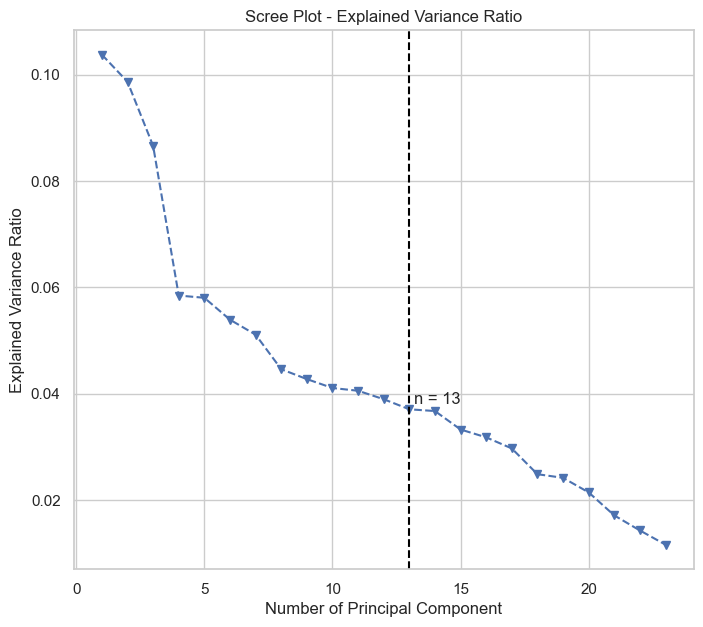

In [64]:
# We create the scree plot
plt.figure(figsize=(8, 7))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='v', linestyle='--', color='b')
plt.title('Scree Plot - Explained Variance Ratio')
plt.xlabel('Number of Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.axvline(x=13,  linestyle='--',color='black')
plt.text(13.2, 0.039, 'n = 13 ', rotation=0, verticalalignment='center')
plt.grid(True)
plt.show()


In this plot, there are significant elbows at $n = 4$ and at $n = 8$. However, the variance explained by these solutions is relatively low, with only 35% captured at $n=4$ and 56% at $n=8$. While these points represent good initial reductions in dimensionality, they may not retain enough information for accurate clustering. A better solution lies at $n=13$, where approximately 76% of the total variance is explained, striking a balance between simplicity and preserving meaningful data variability. 

Then, we decide to select 13 Principal Components to represent our movies features.

---

In [65]:
# We create the dataset of 13 pca components   
pca = PCA(n_components=13)
pca.fit(features_scaled_df)
features_pca = pca.transform(features_scaled_df)
features_pca_df = pd.DataFrame(features_pca, columns=[f'PC{i}' for i in range(1, 14)])
features_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-1.08,9.16,-5.02,3.12,2.54,1.10,-0.42,2.12,-3.00,-2.16,0.41,-0.08,-1.82
1,-1.82,4.64,-2.18,0.44,1.10,0.21,0.55,1.02,-1.26,-1.65,-0.05,1.41,-2.63
2,-0.31,-0.18,-1.22,2.84,-0.07,-0.34,-0.55,-0.11,-0.07,-0.16,0.20,0.58,0.25
3,-0.55,-1.63,-0.96,1.63,-0.09,-1.07,0.65,-0.59,0.35,0.10,0.15,0.40,-0.06
4,-0.46,0.12,-0.52,1.89,-0.12,0.12,-1.16,0.36,-0.67,-0.47,0.26,-0.17,0.06


This cell computes the communalities for each variable to show how much of its variance is explained by the 13 selected principal components. PCA is applied to the standardized data (`features_scaled_df`), and the loadings are calculated to represent the relationship between variables and components. The communalities are then obtained by summing the squared loadings across all components. The resulting DataFrame (`communalities_df`) summarizes how well the selected components capture the variance of each variable, aiding in evaluating the dimensionality reduction.

In [66]:
# Assuming `features_scaled_df` is the standardized data
pca = PCA(n_components=13)  # We set the number of components to 13
pca.fit(features_scaled_df)

# Step 1: Compute the loadings (eigenvectors scaled by the square root of eigenvalues)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Step 2: Compute the communalities
# Square the loadings
squared_loadings = loadings ** 2

# Sum squared loadings across the selected components for each variable
communalities = np.sum(squared_loadings, axis=1)

# Create a DataFrame for clarity
communalities_df = pd.DataFrame({
    'Variable': features_scaled_df.columns,
    'Communalities': communalities
})

# Display the communalities
print(communalities_df)

       Variable  Communalities
0        Action           0.71
1     Adventure           0.58
2     Animation           0.68
3      Children           0.68
4        Comedy           0.83
5         Crime           0.70
6   Documentary           0.86
7         Drama           0.81
8       Fantasy           0.72
9     Film-Noir           0.99
10       Horror           0.66
11         IMAX           0.71
12      Musical           0.86
13      Mystery           0.69
14      Romance           0.60
15       Sci-Fi           0.69
16     Thriller           0.63
17          War           0.95
18      Western           0.96
19  ratings_avg           0.75
20  num_ratings           0.83
21   std_rating           0.64
22     num_tags           0.83


We are able to see that the least explained feature is the Adventure genre binary variable (58%), while the best explained one is the Film-Noir genre (99%). Overall, the features are highly explained.

## **2.3 Clustering**

### **k-means**

First of all, we define our k-means clustering algorithm through the Map-Reduce approach. 

The k-means algorithm is the following:
1. We choose $k$ initial means uniformly at random from our dataset.
2. For each point (movie), we find the closest mean $\mu_i$ and add the movie to a set $C_i$.
3. For $i = 1,...,k$ we update the means  $\mu_i$ (centroids) to be the means of the points in $C_i$.
4. We repeat steps 2 and 3 until the means have converged.

Adopting a MapReduce approach means breaking a task into two phases:

+ Map Phase: Processes data independently in parallel, transforming it into key-value pairs.
+ Reduce Phase: Aggregates the key-value pairs to produce final results.


This approach enables scalable, parallel processing of large datasets across distributed systems, making it efficient and fault-tolerant. 

In K-means clustering, Map assigns points to centroids, and Reduce computes new centroids by averaging cluster points.

---

**Map Phase: Assigning Data Points to Clusters**

In this phase, we assign each data point to the nearest centroid. For each data point, we calculate its distance to all centroids, identify the closest one, and group the point with its respective cluster.

In [67]:
def map_phase(data: np.ndarray, centroids: np.ndarray) -> defaultdict:
    """
    Map phase: Assigns each data point to the nearest centroid.

    This function represents the Map phase of the K-means clustering algorithm in a MapReduce-like framework. 
    For each data point, it calculates the distance to all centroids, finds the closest centroid, 
    and groups the point with its corresponding cluster.

    Args:
        data (np.ndarray): A 2D array of data points, where each row is a point (shape: [n_samples, n_features]).
        centroids (np.ndarray): A 2D array of current centroids (shape: [k, n_features]).

    Returns:
        defaultdict: A dictionary where the keys are cluster IDs (integers) and the values are lists of tuples. 
                     Each tuple contains a data point (np.ndarray) and the integer 1 (used for counting in the Reduce phase).
    """
    # We decide to create a dictionary to store the cluster assignments
    # The key is the cluster ID, and the value is a list of (point, 1) pairs
    mapped = defaultdict(list)

    # We iterate over each data point
    for point in data:
        # Compute the distance from this point to each centroid
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]

        # Find the ID of the closest centroid
        cluster_id = np.argmin(distances)

        # Assign the point to the closest cluster and emit (point, 1)
        mapped[cluster_id].append((point, 1))

    # Return the dictionary containing cluster assignments
    return mapped

**Reduce Phase: Calculating New Centroids**

In this phase, we compute updated centroids by averaging the points assigned to each cluster during the Map phase. This step represents the **Reduce phase** in our MapReduce-based K-means clustering algorithm.


In [68]:
def reduce_phase(mapped: defaultdict) -> np.ndarray:
    """
    Reduce phase: Computes new centroids by averaging the points in each cluster.

    This function represents the Reduce phase of the K-means clustering algorithm in a MapReduce-like framework.
    It takes the clustered points from the Map phase, calculates the mean of points in each cluster, 
    and returns the updated centroids.

    Args:
        mapped (defaultdict): A dictionary where keys are cluster IDs (integers) and values are lists of tuples. 
                              Each tuple contains:
                              - The data point (np.ndarray)
                              - The integer 1 (used for counting the number of points in the cluster).

    Returns:
        np.ndarray: A 2D array of updated centroids, where each row is the mean of the points assigned to a cluster.
                    Shape: [k, n_features], where k is the number of clusters.
    """
    # We initialize an empty list to store the new centroids
    new_centroids = []

    # Then we iterate over each cluster and its associated points
    for cluster_id, points in mapped.items():
        # Extract the points from the list of tuples and compute the sum of all points in this cluster
        sum_points = np.sum([p[0] for p in points], axis=0)

        # Compute the total number of points in this cluster (sum of the second element in the tuples)
        total_count = sum([p[1] for p in points])

        # Calculate the new centroid as the mean of the points in the cluster
        new_centroids.append(sum_points / total_count)

    # Return the new centroids as a NumPy array
    return np.array(new_centroids)

**K-means Clustering with MapReduce**

We implement **K-means clustering** using a MapReduce-like framework to efficiently group data points into clusters. This function iteratively refines cluster centroids and assigns cluster labels to the dataset.

In [69]:
def k_means_mapreduce(
    data: np.ndarray, k: int, tolerance: float = 1e-4, max_iterations: int = 100
) -> tuple[np.ndarray, dict, pd.DataFrame]:
    """
    Implements K-means clustering using a MapReduce-like approach in Python and returns the dataset with cluster labels.

    Args:
        data (np.ndarray): A 2D NumPy array of data points, where each row represents a point.
                           Shape: [n_samples, n_features].
        k (int): The number of clusters to form.
        tolerance (float): The threshold for centroid convergence. When the total shift in centroids is less
                           than this value, the algorithm stops.
        max_iterations (int): The maximum number of iterations to run the algorithm.

    Returns:
        centroids (np.ndarray): A 2D array of the final cluster centroids. Shape: [k, n_features].
        clusters (dict): A dictionary mapping cluster IDs to lists of data points assigned to each cluster.
                         Keys are integers (0 to k-1), and values are lists of data points (np.ndarray).
        labeled_data (pd.DataFrame): A Pandas DataFrame containing the original data with an additional column 
                                     for the assigned cluster.
    """
    # Step 1: We randomly initialize k centroids from the data
    # We set the seed to ensure reproducibility
    np.random.seed(46)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        
        # Step 2: Map phase - Assign each data point to the nearest centroid
        mapped = map_phase(data, centroids)

        # Step 3: Reduce phase - Compute new centroids by averaging the points in each cluster
        new_centroids = reduce_phase(mapped)

        # Step 4: Check for convergence
        # Measure the total shift in centroids using the Frobenius norm (sum of squared changes)
        centroid_shift = np.linalg.norm(centroids - new_centroids, ord='fro')
        
        # If the shift in centroids is less than the tolerance, we stop iterating
        if centroid_shift < tolerance:
            print(f"Converged after {iteration} iterations")
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    if iteration == max_iterations:
        print(f"Stopped after reaching the maximum of {max_iterations} iterations without full convergence.")

    # Step 5: Prepare final cluster assignments
    # Create a dictionary where each cluster ID maps to its assigned points
    clusters = defaultdict(list)
    cluster_labels = []  # To store cluster assignments for each point
    for point in data:
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        cluster_id = np.argmin(distances)  # Assign to the nearest centroid
        clusters[cluster_id].append(point)
        cluster_labels.append(cluster_id +1)

    # Step 6: Add cluster labels to the dataset
    labeled_data = pd.DataFrame(data, columns=[f"PCA_{i+1}" for i in range(data.shape[1])])
    labeled_data["Cluster"] = cluster_labels

    # Return the final centroids, cluster assignments, and labeled dataset
    return centroids, clusters, labeled_data

Implemented the k-means algorithm, we focus on how we can determine the optimal number of clusters for our movie data. 

### **Optimal number of clusters $k$**

**1.** **Elbow method**

In our clustering process, we aim to achieve homogeneity within groups and heterogeneity between groups, ensuring that data points in the same cluster are highly similar while clusters themselves are distinct from one another. The Elbow Method is a visual approach to determining the optimal number of clusters ($k$) in a dataset. It works by evaluating the **Within-Cluster Sum of Squares (WCSS)**, which measures the compactness of the clusters. WCSS is defined as:

$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

Where:
- $k$: Number of clusters.
- $C_i$: The set of points in cluster $i$.
- $\mu_i$: The centroid of cluster $i$.
- $\| x - \mu_i \|$: The Euclidean distance between a point $x$ and its cluster centroid $\mu_i$.

As $k$ increases, WCSS decreases because clusters become smaller and more tightly grouped. The "elbow" point in the plot of $k$ vs. WCSS indicates the optimal number of clusters, where adding more clusters no longer provides significant improvement in compactness. Therefore, this method focuses on evaluating homogeneity within the groups.


**2. Silhouette Analysis**

 **Silhouette Analysis** is a quantitative approach to determining the optimal number of clusters ($k$) by evaluating the separation between clusters and cohesion within clusters.

The **Silhouette Score** for a single data point $x$ is defined as:

$$
s(x) = \frac{b(x) - a(x)}{\max(a(x), b(x))}
$$

Where:
- $a(x)$: The average distance between $x$ and all other points in the same cluster (measures **cohesion**).
- $b(x)$: The average distance between $x$ and all points in the nearest cluster (measures **separation**).
- $s(x)$: Silhouette score for the point $x$, ranging from -1 to 1:
  - $s(x) \approx 1$: Indicates the point is well-matched to its cluster and far from neighboring clusters.
  - $s(x) \approx 0$: Indicates the point is on the boundary between two clusters.
  - $s(x) \approx -1$: Indicates the point is likely misclassified.

The overall **Silhouette Score** is the average $s(x)$ for all points in the dataset. A higher Silhouette Score indicates better-defined clusters.

Unlike the Elbow Method, Silhouette Analysis directly evaluates the quality of clustering by balancing within-cluster cohesion and between-cluster separation, making it an effective tool for determining the optimal $k$. The ideal number of clusters maximizes the Silhouette Score, reflecting both compactness and separation.


**3. Calinski-Harabasz Index**

The **Calinski-Harabasz Index** is a quantitative metric for determining the optimal number of clusters ($k$) by evaluating the ratio of between-cluster dispersion to within-cluster dispersion. A higher score indicates better-defined clusters.

The **Calinski-Harabasz Index** is calculated as:

$$
CH(k) = \frac{\text{Tr}(B_k) / (k - 1)}{\text{Tr}(W_k) / (n - k)}
$$

Where:
- $\text{Tr}(B_k)$: The trace of the between-cluster dispersion matrix, measuring the variance of cluster centroids.
- $\text{Tr}(W_k)$: The trace of the within-cluster dispersion matrix, measuring the variance of points within each cluster.
- $k$: The number of clusters.
- $n$: The total number of data points.


---


In this function, we compute three essential metrics—**Within-Cluster Sum of Squares (WCSS)**, **Silhouette Score**, and **Calinski-Harabasz Index**—to evaluate clustering performance across a range of cluster numbers $k$).

We start by performing clustering using the `k_means_mapreduce` function for each value of $k$. For WCSS, we calculate the total squared distance between data points and their assigned centroids to assess the compactness of the clusters. For $k > 1$, we compute the Silhouette Score, which evaluates how well the clusters are separated while maintaining cohesion within clusters. Additionally, we calculate the Calinski-Harabasz Index, which measures the ratio of between-cluster to within-cluster dispersion.

If $k = 1$, metrics like the Silhouette Score and Calinski-Harabasz Index are skipped because they require at least two clusters. The function returns the results for each metric across the specified range of $k$, providing insights into cluster quality and aiding in selecting the optimal number of clusters.


In [70]:
def compute_clustering_metrics(data: np.ndarray, max_k: int) -> dict:
    """
    Computes WCSS, Silhouette Score, and Calinski-Harabasz Index for a range of cluster numbers.

    Args:
        data (np.ndarray): A 2D NumPy array of data points.
        max_k (int): The maximum number of clusters to evaluate.

    Returns:
        dict: A dictionary with keys 'wcss', 'silhouette', and 'calinski_harabasz' containing lists
              of respective metric values for each cluster count.
    """
    # We initialize a dictionary to store the metrics
    metrics = {
        'wcss': [],                # Stores Within-Cluster Sum of Squares (WCSS)
        'silhouette': [],          # Stores Silhouette Scores
        'calinski_harabasz': []    # Stores Calinski-Harabasz Index values
    }

    # We iterate through a range of cluster numbers (from 1 to max_k)
    for k in range(1, max_k + 1):
        # Perform clustering using our k_means_mapreduce function
        centroids, clusters, labeled_data = k_means_mapreduce(data, k)
        
        # We calculate WCSS by summing the squared distances of points to their respective centroids
        wcss_value = 0
        for cluster_id, points in clusters.items():
            centroid = centroids[cluster_id]
            wcss_value += np.sum([np.linalg.norm(point - centroid)**2 for point in points])
        metrics['wcss'].append(wcss_value)

        # For k=1, we skip Silhouette Score and Calinski-Harabasz Index as they require at least two clusters
        if k > 1:
            # Extract cluster labels from the labeled dataset
            cluster_labels = labeled_data["Cluster"].to_numpy()

            # Calculate the Silhouette Score to evaluate cluster separation and cohesion
            silhouette_value = silhouette_score(data, cluster_labels)
            metrics['silhouette'].append(silhouette_value)

            # Calculate the Calinski-Harabasz Index to measure the ratio of between-cluster to within-cluster dispersion
            ch_value = calinski_harabasz_score(data, cluster_labels)
            metrics['calinski_harabasz'].append(ch_value)
        else:
            # Append None for metrics that are not applicable for k=1
            metrics['silhouette'].append(None)
            metrics['calinski_harabasz'].append(None)

    # We return a dictionary containing the computed metrics
    return metrics


These visualizations help assess the clustering results and provide insights into the optimal number of clusters by showcasing trends in the evaluation metrics across different values of $k$.

In [71]:
def plot_metrics_separately(metrics: dict, max_k: int):
    """
    Plots WCSS, Silhouette Score, and Calinski-Harabasz Index in separate plots.

    Args:
        metrics (dict): A dictionary with keys 'wcss', 'silhouette', and 'calinski_harabasz' containing lists
                        of respective metric values.
        max_k (int): The maximum number of clusters evaluated.
    """
    ks = range(1, max_k + 1)

    # Plot WCSS
    plt.figure(figsize=(8, 5))
    plt.plot(ks, metrics['wcss'], marker='o', linestyle='--', color='b')
    plt.title('Elbow Method (WCSS)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.grid()
    plt.show()

    # Plot Silhouette Score
    plt.figure(figsize=(8, 5))
    plt.plot(ks[1:], metrics['silhouette'][1:], marker='o', linestyle='--', color='g')  # Skip k=1
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

    # Plot Calinski-Harabasz Index
    plt.figure(figsize=(8, 5))
    plt.plot(ks[1:], metrics['calinski_harabasz'][1:], marker='o', linestyle='--', color='r')  # We skip k=1
    plt.title('Calinski-Harabasz Index Analysis')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.grid()
    plt.show()

Converged after 2 iterations
Converged after 47 iterations
Converged after 36 iterations
Converged after 31 iterations
Converged after 19 iterations
Converged after 21 iterations
Converged after 38 iterations
Converged after 80 iterations
Converged after 45 iterations
Converged after 46 iterations


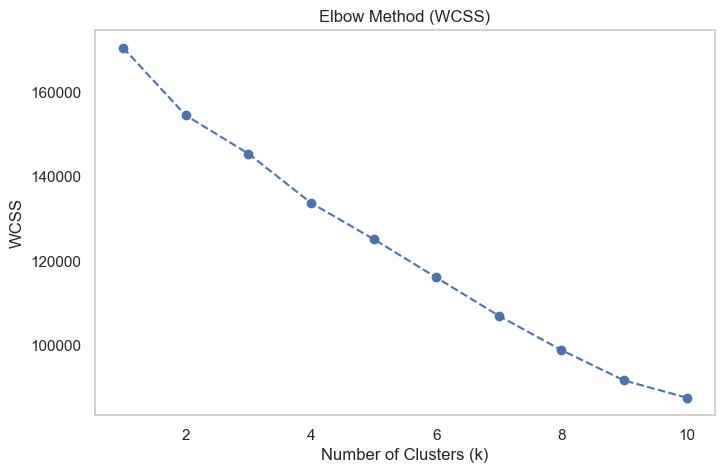

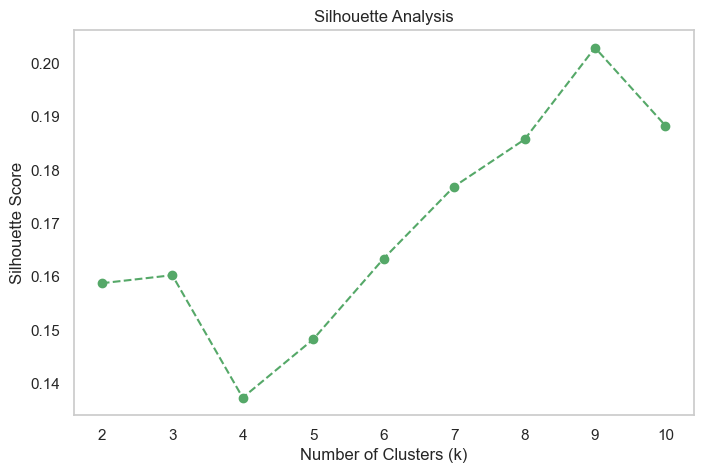

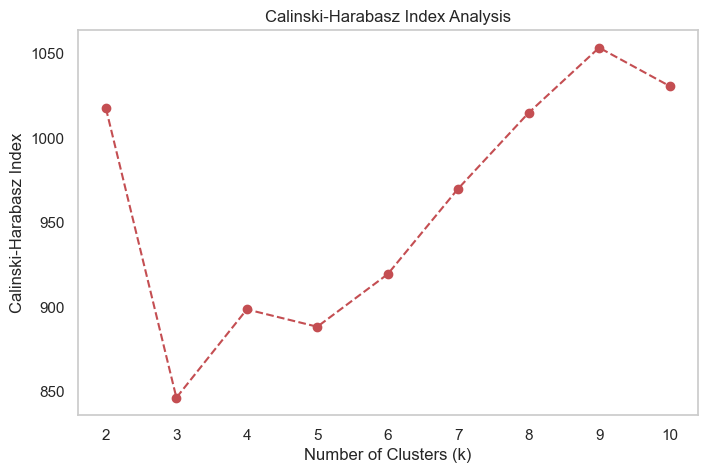

In [72]:
max_k = 10
metrics = compute_clustering_metrics(features_pca, max_k)  # Compute the metrics
plot_metrics_separately(metrics, max_k)  # Plot the metrics in separate plots

For K-means, the optimal number of clusters is chosen as $k = 9$ based on the evaluation metrics.

The **WCSS** metric, which measures the compactness of clusters, shows a significant reduction as $k$ increases. At $k = 9$, the rate of reduction begins to flatten, slightly marking an "elbow point." Beyond this value, additional clusters yield diminishing returns in improving cluster compactness.

The **silhouette score**, which evaluates the quality of clustering in terms of cohesion and separation, peaks at $k = 9$, indicating well-separated and cohesive clusters.

The **Calinski-Harabasz index**, which balances within-cluster compactness and between-cluster separation, also peaks at $k = 9$, making $k = 9$ an optimal choice.

Considering these metrics together, $k = 9$ provides a balance between well-defined clusters and interpretability, making it the most suitable choice for K-means.

### **k-means ++**

First of all, we define our **K-means++ clustering algorithm** through the **Map-Reduce approach**.

The K-means++ algorithm is the following:
1. We select the first centroid randomly from our dataset.
2. For each remaining point, we calculate its distance to the nearest selected centroid.
3. We choose the next centroid with a probability proportional to the square of the distance to the nearest centroid.
4. Repeat step 3 until $k$ centroids are chosen.
5. Once initialized, proceed with standard K-means clustering:
   - Assign each point (movie) to the closest centroid $\mu_i$, forming sets $C_i$.
   - Update centroids $\mu_i$ by calculating the mean of points in $C_i$.
   - Repeat until centroids converge.

Adopting a **MapReduce approach** means dividing the process into two parallel phases:

- **Map** ensures efficient point assignment to clusters.
- **Reduce** guarantees centroid updates, leading to optimal cluster formation.

---


This function implements the **Map phase** of the K-means++ initialization process, where the squared distance of each data point to the nearest centroid is calculated. For each point in the dataset, the function computes its distance to all currently selected centroids and identifies the minimum distance. The result is a collection of points paired with their closest centroid distances, which is used in the subsequent Reduce phase to determine the next centroid for selection.

In [73]:
def kmeans_pp_map(data: np.ndarray, centroids: list) -> list:
    """
    Map phase for K-means++: Computes the squared distance D(x) for each point to the nearest centroid.
    
    Args:
        data (np.ndarray): A 2D array of data points.
        centroids (list): A list of already selected centroids.

    Returns:
        list: A list of tuples where each tuple contains a data point and its squared distance to the nearest centroid.
    """
    # We iterate through each data point and compute its squared distance to the nearest centroid
    mapped = []
    for point in data:
        min_distance = np.min([np.linalg.norm(point - centroid)**2 for centroid in centroids])
        mapped.append((point, min_distance))  
    return mapped


Now, we define the function that represents the **Reduce phase** of the K-means++ initialization process. It selects the next centroid based on the squared distances computed in the Map phase. The function calculates the total sum of all distances and determines the probability of selecting each point, proportional to its squared distance. Using these probabilities, a new centroid is sampled, ensuring a balanced initialization for the K-means algorithm.


In [74]:
def kmeans_pp_reduce(mapped: list) -> tuple:
    """
    Reduce phase for K-means++: Samples a point based on the squared distances computed in the Map phase.
    
    Args:
        mapped (list): A list of tuples containing data points and their squared distances.

    Returns:
        tuple: The next centroid and the total sum of distances.
    """
    # We calculate the total sum of distances to use for sampling probabilities
    total_distance = sum([distance for _, distance in mapped])
    probabilities = [distance / total_distance for _, distance in mapped]

    # We select the next centroid with probability proportional to its squared distance
    selected_index = np.random.choice(len(mapped), p=probabilities)
    return mapped[selected_index][0]


In this step, we initialize centroids for the K-means++ algorithm using a MapReduce approach. We start by randomly selecting the first centroid from the dataset to kick off the process. Then, for each subsequent iteration, we alternate between two key phases:

- **Map Phase**: Here, we calculate the squared distances from all points in the dataset to the nearest centroid, ensuring we accurately capture how points are distributed relative to the current centroids.
- **Reduce Phase**: Using the distances computed in the Map phase, we sample the next centroid, with points farther from existing centroids having a higher probability of selection.

We repeat this process until we have chosen $k$ centroids. 

In [75]:
def kmeans_pp_initialization(data: np.ndarray, k: int) -> np.ndarray:
    """
    Initializes centroids using the K-means++ algorithm via MapReduce.
    
    Args:
        data (np.ndarray): A 2D array of data points.
        k (int): Number of clusters.

    Returns:
        np.ndarray: A 2D array of k initial centroids.
    """
    # Step 1: Randomly select the first centroid
    centroids = [data[np.random.choice(data.shape[0])]]

    # Step 2: Select remaining k-1 centroids
    for i in range(k - 1):
        # Map phase: Compute squared distances for all points to the nearest centroid
        mapped = kmeans_pp_map(data, centroids)
    
        # Reduce phase: Sample the next centroid based on distance probabilities
        next_centroid = kmeans_pp_reduce(mapped)
        centroids.append(next_centroid)
        
    # We return the final set of k centroids
    return np.array(centroids)

To ensure a strong start for clustering, we first initialize the centroids using the K-means++ strategy, which distributes the initial centroids strategically across the dataset.

The process is iterative, with each step involving two key phases:

- **Map Phase**: In this phase, we assign each data point to its nearest centroid, effectively grouping the data into clusters.
- **Reduce Phase**: Here, we update the centroids by calculating the average position of all points within each cluster, ensuring that the centroids reflect the current grouping.

We repeat these phases until the centroids stabilize (indicating convergence) or the maximum number of iterations is reached. At the end of the process, we produce three key outputs: the final refined centroids, the cluster assignments for the data points, and a labeled dataset where each point is associated with its respective cluster.

In [76]:
def k_means_plus_plus_mapreduce(data: np.ndarray, k: int, tolerance: float = 1e-4, max_iterations: int = 100):
    """
    Implements K-means++ clustering using a MapReduce-like approach.
    
    Args:
        data (np.ndarray): A 2D array of data points.
        k (int): Number of clusters.
        tolerance (float): Convergence threshold.
        max_iterations (int): Maximum number of iterations.

    Returns:
        tuple: Final centroids, cluster assignments, and labeled data.
    """
    # Step 1: We initialize centroids using K-means++ via MapReduce
    # Setting the seed for reproducibility
    np.random.seed(24)

    centroids = kmeans_pp_initialization(data, k)
    
    iteration = 0
    while iteration < max_iterations:
        iteration += 1

        # Map Phase: Assign points to clusters
        mapped = defaultdict(list)
        for point in data:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_id = np.argmin(distances)
            mapped[cluster_id].append((point, 1))  # Emit (cluster_id, (point, 1))
        
        # Reduce Phase: Compute new centroids
        new_centroids = []
        for cluster_id, points in mapped.items():
            sum_points = np.sum([p[0] for p in points], axis=0)
            total_count = sum([p[1] for p in points])
            new_centroids.append(sum_points / total_count)  # New centroid as the mean of points in the cluster
        
        new_centroids = np.array(new_centroids)

        # We check if the algorithm converges
        centroid_shift = np.linalg.norm(centroids - new_centroids)
        if centroid_shift < tolerance:
            print(f"Converged after {iteration} iterations.")
            break

        centroids = new_centroids

    # Final cluster assignments
    clusters = defaultdict(list)
    cluster_labels = []
    for point in data:
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        cluster_id = np.argmin(distances)
        clusters[cluster_id].append(point)
        cluster_labels.append(cluster_id + 1)

    #  We add cluster labels to the dataset
    labeled_data = pd.DataFrame(data, columns=[f"PCA_{i+1}" for i in range(data.shape[1])])
    labeled_data["Cluster"] = cluster_labels

    # We return the final centroids, cluster assignments, and labeled dataset
    return centroids, clusters, labeled_data

Again, we compute the three clustering metrics.

In [77]:
def kplus_plus_clustering_metrics(data: np.ndarray, max_k: int) -> dict:
    """
    Computes WCSS, Silhouette Score, and Calinski-Harabasz Index for a range of cluster numbers.

    Args:
        data (np.ndarray): A 2D NumPy array of data points.
        max_k (int): The maximum number of clusters to evaluate.

    Returns:
        dict: A dictionary with keys 'wcss', 'silhouette', and 'calinski_harabasz' containing lists
              of respective metric values for each cluster count.
    """
    # We again initialize a dictionary to store the metrics
    metrics = {
        'wcss': [],                # Stores Within-Cluster Sum of Squares (WCSS)
        'silhouette': [],          # Stores Silhouette Scores
        'calinski_harabasz': []    # Stores Calinski-Harabasz Index values
    }

    # We iterate through a range of cluster numbers (from 1 to max_k)
    for k in range(1, max_k + 1):
        # Perform clustering using our k_means_mapreduce function
        centroids, clusters, labeled_data = k_means_plus_plus_mapreduce(data, k)
        
        # Calculate WCSS by summing the squared distances of points to their respective centroids
        wcss_value = 0
        for cluster_id, points in clusters.items():
            centroid = centroids[cluster_id]
            wcss_value += np.sum([np.linalg.norm(point - centroid)**2 for point in points])
        metrics['wcss'].append(wcss_value)

        # For k=1, we skip Silhouette Score and Calinski-Harabasz Index as they require at least two clusters
        if k > 1:
            # Extract cluster labels from the labeled dataset
            cluster_labels = labeled_data["Cluster"].to_numpy()

            # Calculate the Silhouette Score to evaluate cluster separation and cohesion
            silhouette_value = silhouette_score(data, cluster_labels)
            metrics['silhouette'].append(silhouette_value)

            # Calculate the Calinski-Harabasz Index to measure the ratio of between-cluster to within-cluster dispersion
            ch_value = calinski_harabasz_score(data, cluster_labels)
            metrics['calinski_harabasz'].append(ch_value)
        else:
            # Append None for metrics that are not applicable for k=1
            metrics['silhouette'].append(None)
            metrics['calinski_harabasz'].append(None)

    # We return a dictionary containing the computed metrics
    return metrics

Converged after 2 iterations.
Converged after 38 iterations.
Converged after 15 iterations.
Converged after 44 iterations.
Converged after 44 iterations.
Converged after 27 iterations.
Converged after 46 iterations.
Converged after 45 iterations.
Converged after 18 iterations.
Converged after 18 iterations.


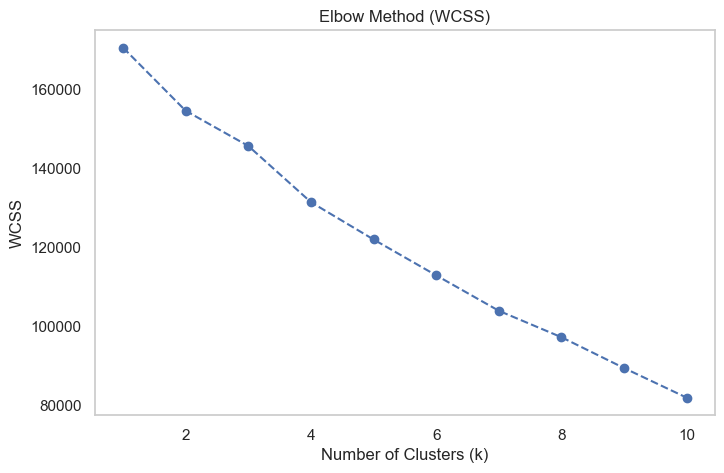

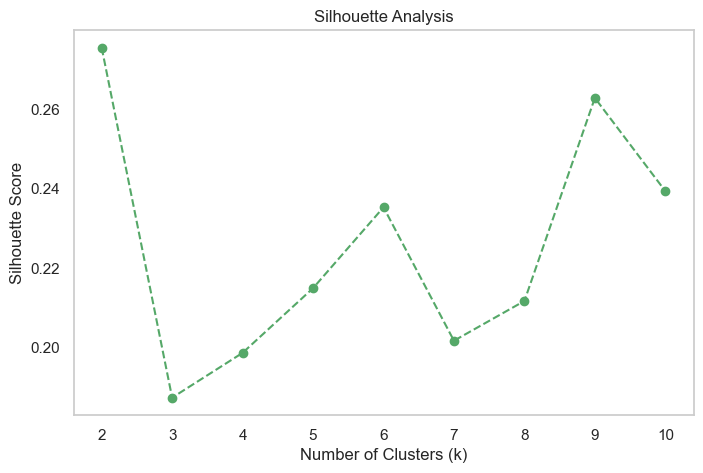

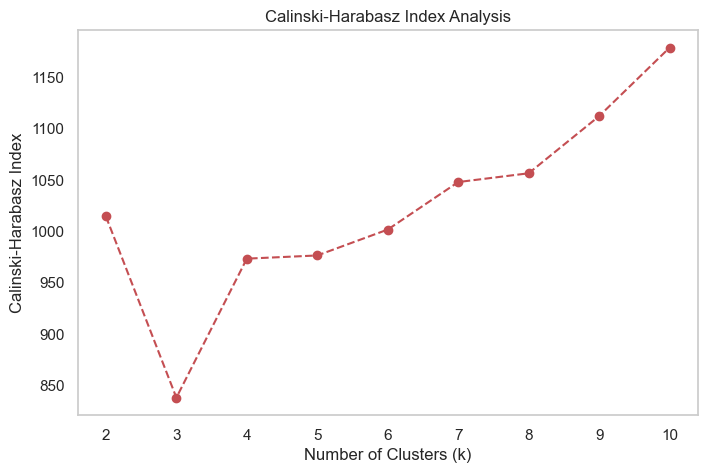

In [78]:
metrics_pp = kplus_plus_clustering_metrics(features_pca, max_k)  # Compute the metrics
plot_metrics_separately(metrics_pp, max_k)  # Plot the metrics in separate plots

For K-means++, the optimal number of clusters is chosen as $k = 9$ based on the evaluation metrics.

The **WCSS** metric, which measures the compactness of clusters, shows a consistent reduction as $k$ increases. However, there is no evident elbow point and we then focus on silhouette score and Calinski-Harabasz index.

The **silhouette score**, which evaluates the quality of clustering in terms of cohesion and separation, peaks at $k = 9$, showing that when we consider a partition in 9 groups, this solution highly explains our movies information.

The **Calinski-Harabasz index**, which balances within-cluster compactness and between-cluster separation, continues to increase up to $k = 10$. However, we choose to select $k = 9$ since the index display a reasonably high value. 

Considering the balance between well-defined clusters, computational efficiency, and interpretability, $k = 9$ emerges as the optimal choice for K-means++.

---

### **Ward's Method**

Now, we ask an LLM to recommend another clustering algorithm. It suggested to implement a hierarchical cluster analysis through Ward's Method. Therefore, we provide an explanation for this algorithm:

**Ward's Method in Hierarchical Cluster Analysis**

Ward's Method is a hierarchical clustering technique that focuses on minimizing the **variance within clusters** as they are merged. It is widely regarded as one of the most effective approaches for hierarchical clustering when the goal is to produce compact and homogeneous clusters.

---

**How Ward's Method Works**

1. **Initial State**:
   - Each data point starts as its own cluster (singleton clusters).

2. **Distance Calculation**:
   - For every possible pair of clusters, Ward's Method calculates the **increase in within-cluster variance** (also called Ward’s criterion) that would result from merging the clusters.

3. **Cluster Merging**:
   - The pair of clusters that results in the smallest increase in within-cluster variance is merged.

4. **Iteration**:
   - Steps 2 and 3 are repeated until all data points are merged into a single cluster or the desired number of clusters is reached.

---

**Mathematical Intuition**

Ward’s criterion minimizes the total sum of squared deviations from the mean (also called **error sum of squares** or ESS). 

- For a cluster $C$, the variance is represented as:
  $$
  \text{ESS} = \sum_{x \in C} ||x - \mu||^2
  $$
  where:
  - $x$ is a data point.
  - $\mu$ is the mean (centroid) of the cluster.

- When merging two clusters, Ward’s Method selects the pair that results in the **smallest increase** in total ESS across all clusters.

---

**Key Features**

- **Agglomerative**:
  - Ward’s Method starts with individual points and iteratively merges clusters until a stopping criterion is met (e.g., desired number of clusters).

- **Linkage Criterion**:
  - Uses the increase in total variance (ESS) as the linkage criterion, differing from methods like single-linkage (minimum distance) or complete-linkage (maximum distance).

---

**Advantages**

1. **Compact Clusters**:
   - Tends to produce clusters that are compact and evenly sized due to its focus on minimizing variance.

2. **Handles Multivariate Data**:
   - Effective for datasets with multiple features and can be applied in various domains.

3. **Dendrograms**:
   - Provides a hierarchical structure that can be visualized with a dendrogram, allowing for flexible exploration of cluster counts.

---

**Disadvantages**

1. **Scalability**:
   - Computationally expensive with a time complexity of $O(n^3)$ for dense distance matrices and $O(n^2)$ for efficient implementations. This makes it less suitable for very large datasets.

2. **Sensitive to Outliers**:
   - Outliers can have a disproportionate effect on the clusters since they can significantly increase the within-cluster variance.

3. **Assumes Euclidean Space**:
   - Assumes clusters are defined in terms of Euclidean distances, which might not be suitable for some datasets.

---

**Comparison with K-means and K-means++**

- **Cluster Shape**:
  - Ward's Method can handle non-spherical clusters better than K-means, which assumes clusters are spherical and similar in size.

- **Number of Clusters**:
  - Ward's Method does not require predefining the number of clusters. Instead, a dendrogram is generated, allowing flexibility in choosing the cluster count. K-means and K-means++ require specifying $k$ beforehand.

- **Initialization**:
  - Ward's Method does not involve random initialization like K-means. This avoids issues with unstable clustering results that can arise from poor initialization in standard K-means (though K-means++ mitigates this by improving initialization).

- **Outlier Handling**:
  - Ward's Method can be sensitive to outliers since it minimizes variance, which can be disproportionately affected by extreme values. K-means++ is similarly sensitive, while DBSCAN may outperform both in handling outliers.

- **Scalability**:
  - K-means and K-means++ are more scalable. In contrast, Ward's Method has higher computational requirements, making it less suitable for very large datasets.

---

Then, we implement Ward's Method in our case, obtaining the three evaluation metrics previously considered:

In [79]:
# We initialize three lists to store metrics
wcss_ward = []  # Within-Cluster Sum of Squares
silhouette_scores = []  # Silhouette Scores
calinski_harabasz_scores = []  # Calinski-Harabasz Index
max_k = 10
# Iterate over cluster numbers from 1 to max_k
for k in range(1, max_k + 1):
    # Apply Agglomerative Clustering with Ward's Method
    ward_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = ward_clustering.fit_predict(features_pca)
    
    # Compute WCSS
    wcss_value = 0
    unique_clusters = np.unique(cluster_labels)
    for cluster_id in unique_clusters:
        cluster_points = features_pca[cluster_labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        wcss_value += np.sum((cluster_points - centroid) ** 2)
    wcss_ward.append(wcss_value)

    # Silhouette and Calinski-Harabasz require at least 2 clusters
    if k > 1:
        silhouette = silhouette_score(features_pca, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(features_pca, cluster_labels)
        silhouette_scores.append(silhouette)
        calinski_harabasz_scores.append(calinski_harabasz)
    else:
        silhouette_scores.append(None)
        calinski_harabasz_scores.append(None)

We plot our results.

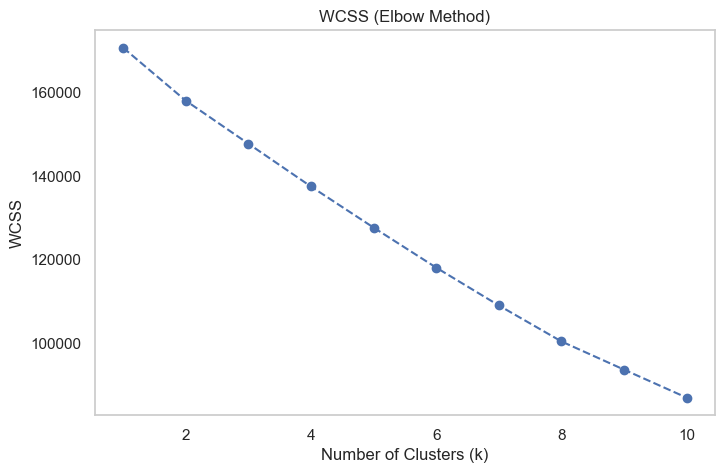

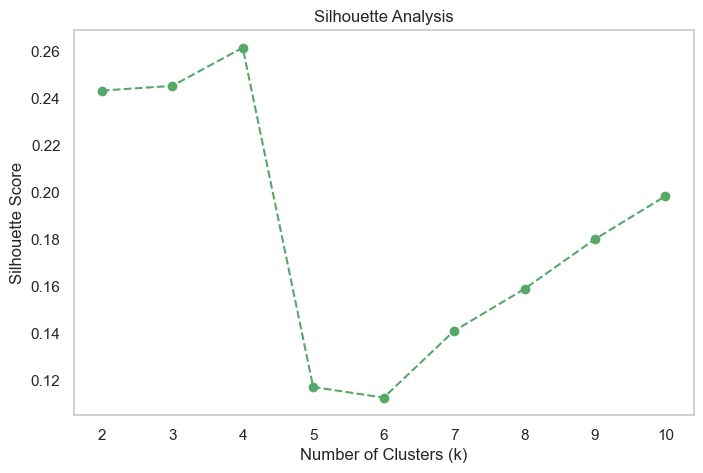

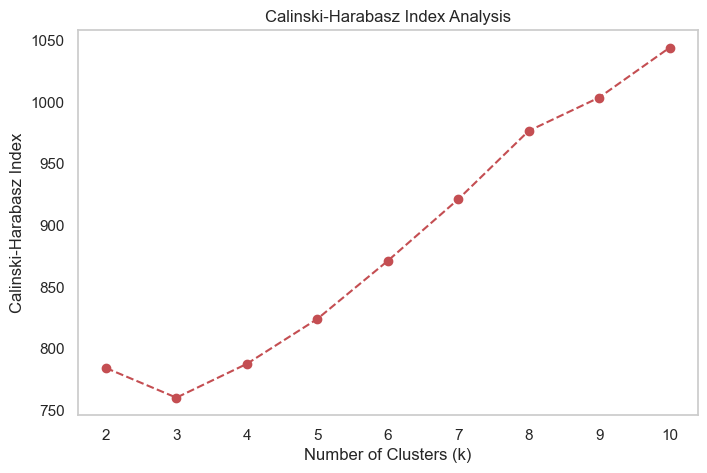

In [80]:
# Plot the metrics
# Plot WCSS
plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), wcss_ward, marker='o', linestyle='--', color='b')
plt.title('WCSS (Elbow Method)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.grid()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_k + 1), silhouette_scores[1:], marker='o', linestyle='--', color='g')  # Skip k=1
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

# Plot Calinski-Harabasz Index
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_k + 1), calinski_harabasz_scores[1:], marker='o', linestyle='--', color='r')  # Skip k=1
plt.title('Calinski-Harabasz Index Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.grid()
plt.show()

We decide to display the **dendrogram** for the last 10 clusters of the agglomerative process: 

A dendrogram is a tree-like diagram that visually represents the hierarchical clustering process, showing how individual data points or clusters merge at increasing levels of dissimilarity. The x-axis represents the clusters or data points, and the y-axis indicates the distance or dissimilarity at which merges occur.

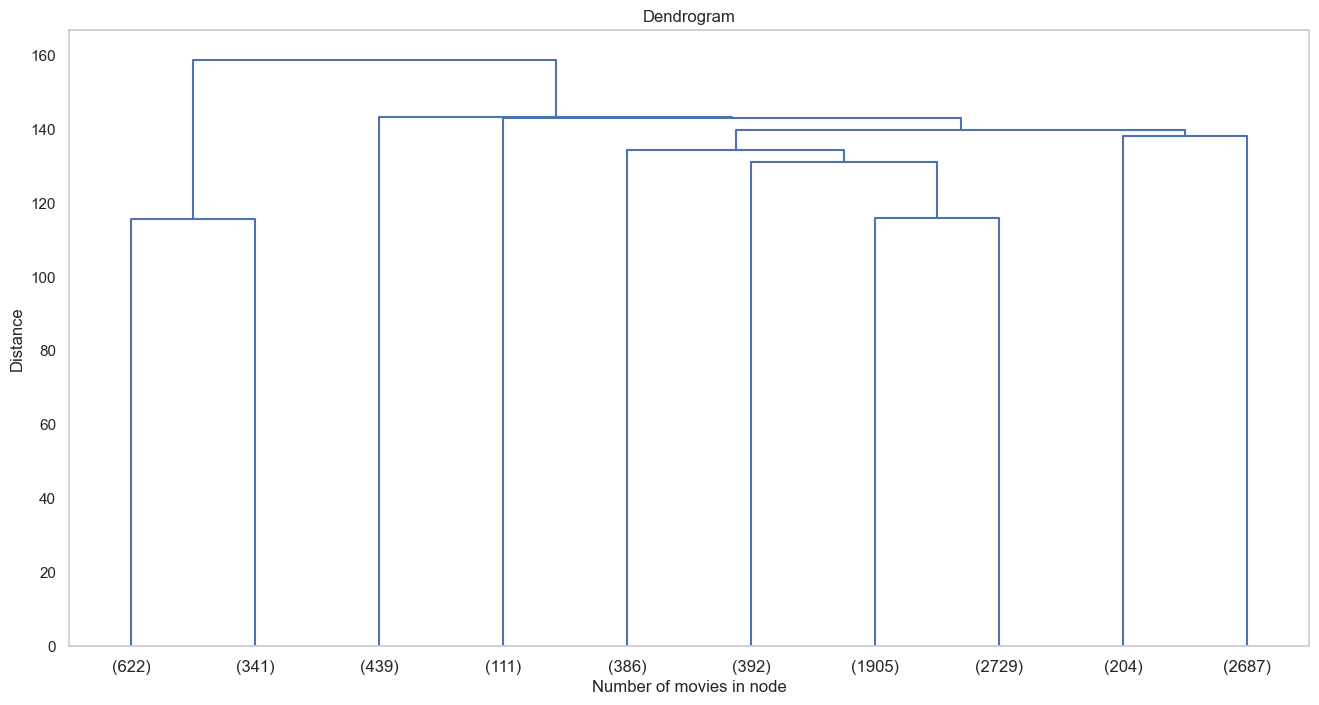

In [81]:
# We display the dendrogram

plt.figure(figsize=(16, 8))

# We plot the dendrogram for the first 10 clusters

dendrogram(linkage(features_pca, method='ward'), truncate_mode='lastp', p=10)
plt.title('Dendrogram')
plt.xlabel('Number of movies in node')
plt.ylabel('Distance')
plt.grid()
plt.show()

The dendrogram provides a visual representation of the hierarchical clustering process using Ward's method, truncated to display the last 10 clusters. The x-axis shows the cluster labels, while the y-axis represents the distances or dissimilarities at which clusters are merged. At $k = 9$, we can observe that the clusters are well-defined, with distinct separations between the vertical branches, indicating meaningful divisions in the data. The height at which clusters merge gives insight into their similarity, with shorter branches representing more cohesive clusters and taller branches reflecting greater dissimilarity between clusters.


## **2.4 Best Algorithm**

**1.** 

Based on the evaluation metrics for K-means, K-means++, and Agglomerative Clustering with Ward's method, we believe that $k = 9$ is the optimal choice for the following reasons.

For WCSS, across all algorithms, there is a steady decrease as $k$ increases, reflecting improved compactness. While the "elbow point" indicating diminishing returns in WCSS reduction appears around $k = 8$, the reduction continues significantly up to $k = 9$, suggesting a meaningful improvement in compactness at this level.

For the silhouette score, which evaluates the cohesion and separation of clusters, K-means++ achieves its highest value at $k = 9$ with $0.2628$. This indicates that the clusters are well-separated and cohesive at this level. Although K-means and Ward's method show their highest silhouette scores at slightly lower values of $k$, the scores for $k = 9$ remain competitive, supporting our choice.

For the Calinski-Harabasz index, which balances within-cluster compactness and between-cluster separation, K-means++ again shows its peak at $k = 9$. While the index for Ward's method continues to increase, the improvement from $k = 8$ to $k = 9$ is more pronounced, emphasizing better-defined clusters at this value.

Considering all three metrics, $k = 9$ provides a strong balance across compactness, separation, and interpretability. The alignment of metrics for K-means++ and the competitive results for K-means and Ward's method at this level reinforce our decision. This choice ensures that clusters are both meaningful and computationally manageable, making $k = 9$ the optimal choice.


---

**2.**

We chose to base our analysis on three evaluation metrics: *Within-Cluster Sum of Squares*, *Silhouette*, *Calinski-Harabasz*.

We briefly reintroduce the metrics: 

1. **Within-Cluster Sum of Squares (WCSS)**: Measures the compactness of clusters by summing the squared distances of data points to their cluster centroids. Lower WCSS indicates tighter and more compact clusters. It is defined as:

   $$
   \text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
   $$

   Where:
   - $k$: Number of clusters
   - $C_i$: Points in cluster $i$
   - $\mu_i$: Centroid of cluster $i$
   - $\| x - \mu_i \|$: Euclidean distance between a point $x$ and its cluster centroid

2. **Silhouette Score**: Evaluates both the cohesion within clusters and the separation between clusters. It ranges from -1 to 1, where a higher score indicates better-defined and well-separated clusters. For a single point $x$, the silhouette score is:

   $$
   s(x) = \frac{b(x) - a(x)}{\max(a(x), b(x))}
   $$

   Where:
   - $a(x)$: Average distance of $x$ to other points in the same cluster (cohesion)
   - $b(x)$: Average distance of $x$ to points in the nearest cluster (separation)

3. **Calinski-Harabasz Index**: Assesses the ratio of between-cluster dispersion to within-cluster dispersion. Higher values signify well-separated and compact clusters. It is defined as:

   $$
   \text{CH(k)} = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{n - k}{k - 1}
   $$

   Where:
   - $\text{Tr}(B_k)$: Trace of the between-cluster dispersion matrix
   - $\text{Tr}(W_k)$: Trace of the within-cluster dispersion matrix
   - $n$: Total number of points
   - $k$: Number of clusters


Each clustering evaluation metric focuses on different aspects of cluster quality, providing complementary insights:

1. **Within-Cluster Sum of Squares (WCSS)** focuses on **compactness** by measuring how closely the points in each cluster are grouped around their centroid. Lower WCSS values indicate tighter, more compact clusters, which implies good intra-cluster cohesion. However, WCSS does not consider inter-cluster separation, so it cannot evaluate how distinct clusters are from one another.

2. **Silhouette Score** balances two aspects: **cohesion** (how close points are within the same cluster) and **separation** (how distinct a cluster is from others). A high silhouette score indicates that clusters are both compact and well-separated, making it a well-rounded metric for evaluating clustering quality.

3. **Calinski-Harabasz Index** emphasizes the **separation** between clusters relative to their **compactness** by analyzing the ratio of between-cluster variance to within-cluster variance. A higher index value reflects well-separated and dense clusters, highlighting the trade-off between compactness and separation.


---

We use the three clustering algorithms from the previous section to divide the data into $k = 9$ clusters. We evaluate the quality of each model using the chosen metrics and compare their results to summarize our observations.

In [82]:
# k-means clustering
k = 9
pca_kmeans = k_means_mapreduce(features_pca, k)[2]
movies_features['Cluster-kmeans'] = pca_kmeans['Cluster']

Converged after 45 iterations


In [83]:
# k-means++ clustering
pca_kmeanspp = k_means_plus_plus_mapreduce(features_pca, k)[2]
movies_features['Cluster-kmeans++'] = pca_kmeanspp['Cluster']

Converged after 18 iterations.


In [84]:
# Agglomerative clustering: Ward's Method
ward_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
ward_labels = ward_clustering.fit_predict(features_pca) + 1
movies_features['Cluster-ward'] = ward_labels
movies_features.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Western,ratings_avg,relevant_genome_tag,common_user_tag,num_ratings,std_rating,num_tags,Cluster-kmeans,Cluster-kmeans++,Cluster-ward
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,3.92,toys,Pixar,49695,0.89,84,1,1,1
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,3.21,adventure,Robin Williams,22243,0.95,35,2,2,1
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,3.15,good sequel,moldy,12735,1.01,15,3,3,5
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,2.86,women,chick flick,2756,1.10,4,3,3,5
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,3.06,good sequel,steve martin,12161,0.98,17,3,3,5


In [85]:
def generate_cluster_radar_charts(data: pd.DataFrame, cluster_column: str, feature_columns: list, color: str = 'blue'):
    """
    Creates radar charts to visually profile clusters based on normalized feature centroids, displayed in a 3x3 grid.

    Args:
        data (pd.DataFrame): Dataset containing features and cluster labels.
        cluster_column (str): Column name indicating cluster assignments.
        feature_columns (list): List of numerical feature column names for visualization.
        color (str): Color to use for the radar chart plots (default: 'blue').

    Returns:
        None: Displays radar charts for each cluster in a grid layout, profiling their feature distributions.
    """
    # We calculate the average feature values (centroids) for each cluster
    cluster_centroids = data.groupby(cluster_column)[feature_columns].mean()

    # Then we normalize the centroids for comparability
    normalized_centroids = cluster_centroids / cluster_centroids.max()

    # We define the feature angles for the radar chart
    num_features = len(feature_columns)
    angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
    angles += angles[:1]  # Close the circle for the radar chart

    # Get cluster sizes for additional context
    cluster_sizes = data[cluster_column].value_counts().sort_index()

    # Prepare grid layout for 3x3 plots
    num_clusters = len(normalized_centroids)
    num_rows = (num_clusters + 2) // 3  # Ensure enough rows for all clusters
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), subplot_kw={'polar': True})
    axes = axes.flatten()

    # Generate radar charts for each cluster
    for idx, cluster_label in enumerate(normalized_centroids.index):
        ax = axes[idx]  # Select the corresponding subplot

        # Extract values for the current cluster and close the circle
        cluster_values = normalized_centroids.loc[cluster_label].tolist()
        cluster_values += cluster_values[:1]

        # Plot and fill the radar chart for the current cluster
        ax.plot(angles, cluster_values, linewidth=2, linestyle='solid', label=f'Cluster {cluster_label}', color=color)
        ax.fill(angles, cluster_values, alpha=0.2, color=color)

        # Customize the chart with feature names and cluster details
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(feature_columns, color='black', size=8)
        ax.set_title(f"Cluster {cluster_label}\n(Size: {cluster_sizes[cluster_label]})", size=12, color='black', y=1.1)

    # Turn off unused subplots
    for ax in axes[num_clusters:]:
        ax.axis('off')

    # Adjust layout and display the grid
    plt.tight_layout()
    plt.show()

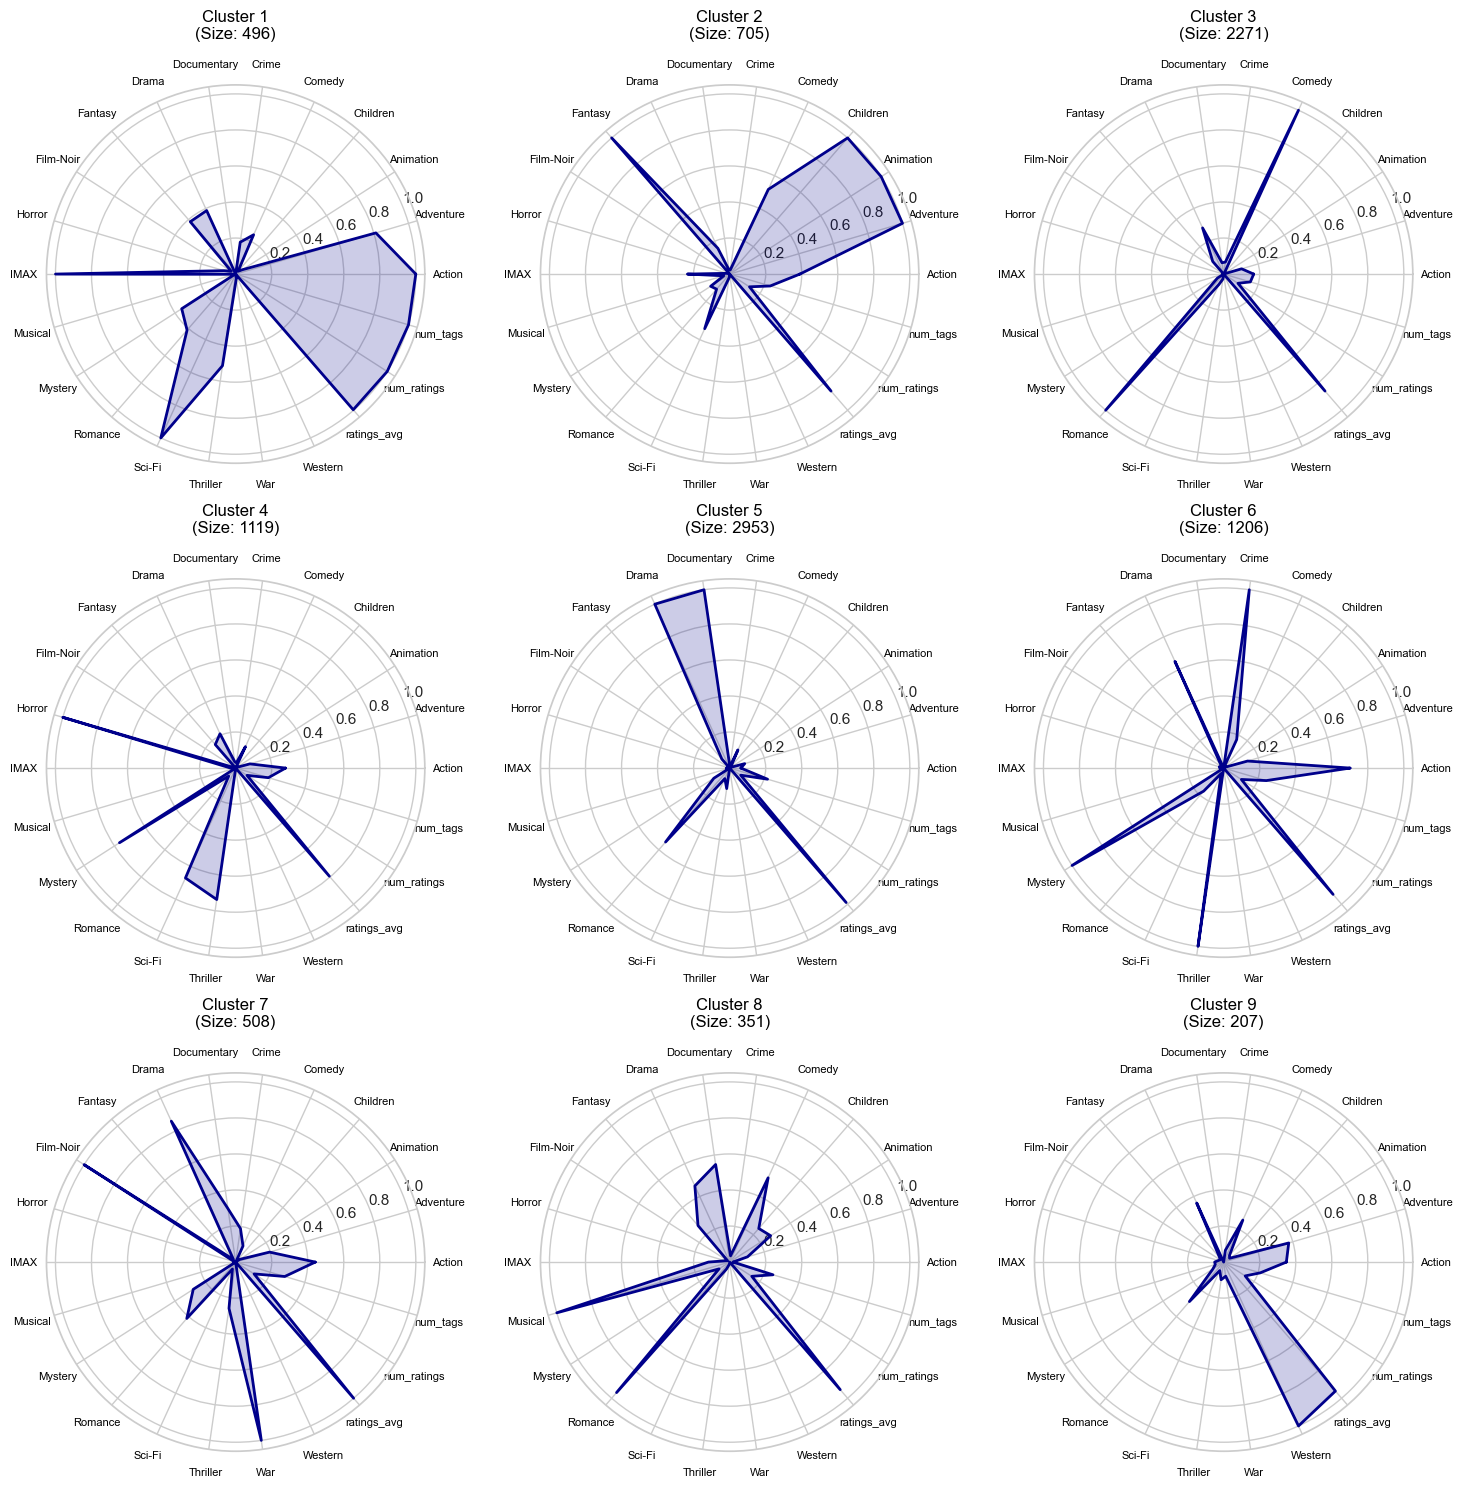

In [86]:
numerical_features = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy',
                      'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                      'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                      'War', 'Western', 'ratings_avg', 'num_ratings', 'num_tags']

generate_cluster_radar_charts(data = movies_features, cluster_column = 'Cluster-kmeans', feature_columns = numerical_features, color = 'darkblue')

**Cluster Analysis of Movies** (*k-means*)

Now we analyze the 9 clusters created with our *k-means* algorithm:

**Cluster 1** (Size: 496) - *Widely Popular Action-Adventure*  
This cluster represents movies that span action and adventure genres with relatively high average ratings and a significant number of ratings. These films often appeal to mainstream audiences and are likely high-budget productions with broad appeal.

**Cluster 2** (Size: 705) - *Family-Friendly Animated Films*  
Cluster 2 is dominated by animation and children-oriented genres. These movies have moderate average ratings but are highly popular among younger audiences and families, likely including titles from major studios like Pixar and Disney.

**Cluster 3** (Size: 2271) - *Mass Appeal Comedies*  
The largest cluster is primarily centered on comedy genres. These movies are widely appealing, with moderate average ratings and a high number of ratings. They are often designed for lighthearted, general entertainment.

**Cluster 4** (Size: 1119) - *Niche Suspense Thrillers*  
This cluster includes movies with strong associations to thriller and suspense genres. They tend to have average ratings and moderate popularity but attract passionate audiences who engage deeply with these films.

**Cluster 5** (Size: 2953) - *Critically Acclaimed Dramas*  
This is the largest cluster, featuring movies with slightly above-average ratings and fewer tags. These films often appeal to audiences looking for emotionally impactful or thought-provoking narratives.

**Cluster 6** (Size: 1206) - *Engaging Mysteries and Thrillers*  
Cluster 6 groups movies with strong representations in mystery and thriller genres. These films tend to have above-average ratings and high levels of tags, showcasing their ability to intellectually engage their viewers.

**Cluster 7** (Size: 508) - *Cinematic Classics*  
This smaller cluster highlights films in traditional or artistic genres such as film-noir, historical drama, and war. These movies often appeal to cinephiles who appreciate classical storytelling and timeless narratives.

**Cluster 8** (Size: 351) - *Romantic and Sentimental Favorites*  
Cluster 8 focuses on romance and musicals, often featuring emotional and uplifting themes. These films cater to audiences seeking sentimental and feel-good experiences.

**Cluster 9** (Size: 207) - *Specialized Western Adventures*  
The smallest cluster groups Western and adventure films, showcasing a niche genre with loyal audiences. These movies emphasize themes of exploration, survival, and independence.

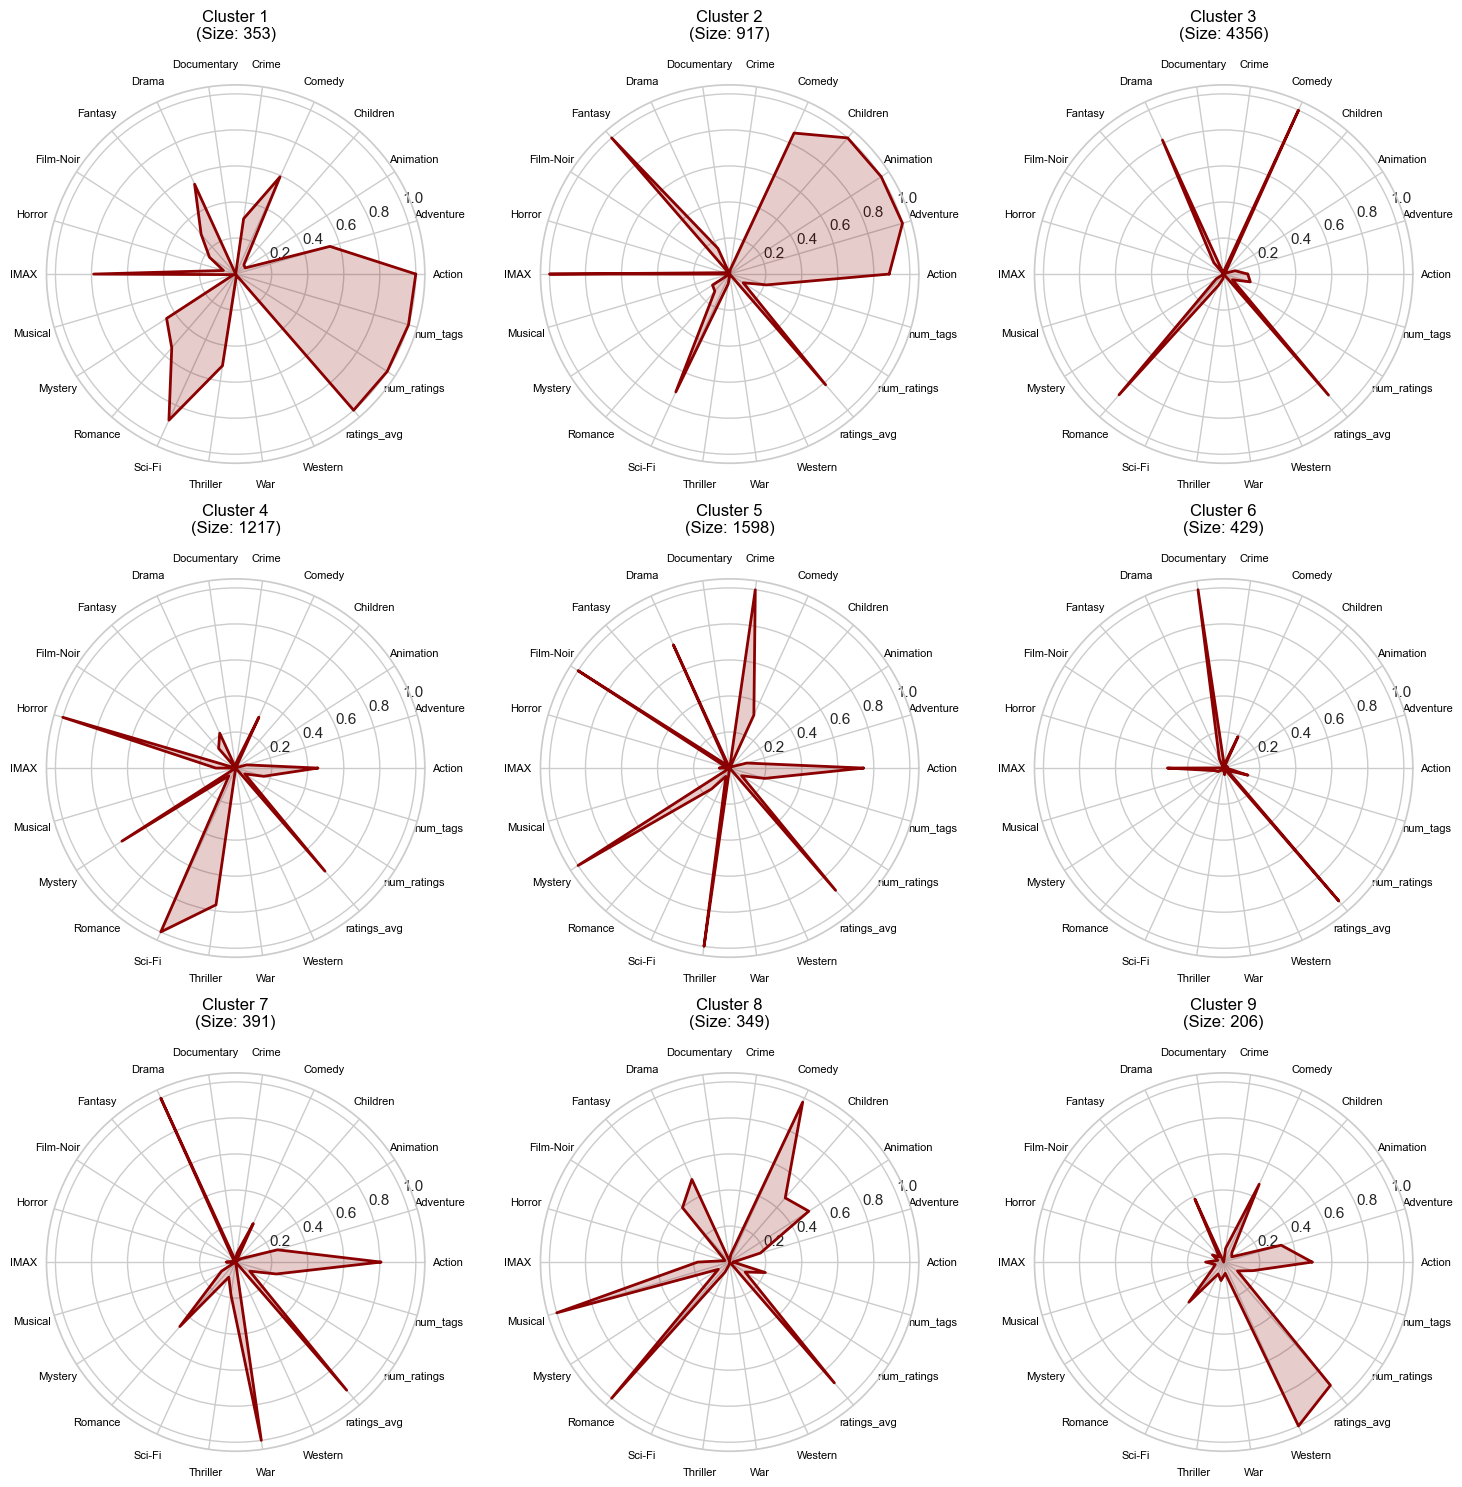

In [87]:
generate_cluster_radar_charts(data = movies_features, cluster_column = 'Cluster-kmeans++', feature_columns = numerical_features, color = 'darkred')

**Cluster Analysis of Movies** (*k-means++*)

We now analyze the 9 clusters created with our *k-means++* algorithm based on the radar charts provided. Each cluster represents distinct characteristics within the movie dataset:

---

**Cluster 1** (Size: 353) - *Action-Packed Favorites*  
This cluster predominantly focuses on action and thriller genres, with high values for attributes like *Action* and *Thriller*. These movies are likely fast-paced, adrenaline-filled blockbusters that appeal to thrill-seeking audiences. The ratings and tags indicate strong engagement but moderate audience diversity.

---

**Cluster 2** (Size: 917) - *Family-Oriented Animated Features*  
Cluster 2 is primarily centered on animation, children, and fantasy genres, suggesting movies designed for younger audiences and families. The high relevance of these genres, paired with substantial ratings, suggests the presence of classics from studios like Disney or Pixar.

---

**Cluster 3** (Size: 4356) - *Mass Appeal Comedies and Dramas*  
The largest cluster includes movies that excel in comedy and drama genres. These films tend to have wide appeal, moderate average ratings, and attract large audiences. They are likely general-purpose movies designed for entertainment without being genre-specific.

---

**Cluster 4** (Size: 1217) - *Horror Enthusiasts’ Collection*  
Cluster 4 heavily features horror as its defining genre, with smaller contributions from thrillers. These movies likely appeal to niche but dedicated horror fans, with above-average ratings and a smaller but highly engaged audience.

---

**Cluster 5** (Size: 1598) - *Critically Acclaimed Documentaries and Dramas*  
This cluster is defined by its focus on documentary and drama genres. These films likely cater to viewers who prefer intellectually stimulating or emotionally engaging narratives. They show moderate engagement but have a significant presence in the dataset.

---

**Cluster 6** (Size: 429) - *Mysterious Action Films*  
Cluster 6 is characterized by its focus on action and mystery genres, with minor contributions from thrillers. These films are likely designed for audiences looking for suspenseful and high-energy narratives, offering intellectually engaging plots with fast-paced action.

---

**Cluster 7** (Size: 391) - *Classic War and Historical Dramas*  
Cluster 7 features movies within historical, war, and drama genres, emphasizing traditional cinematic styles. These films likely appeal to cinephiles who appreciate timeless storytelling and nuanced character studies.

---

**Cluster 8** (Size: 349) - *Musical Romance and Feel-Good Films*  
Cluster 8 focuses on romance and musical genres, with themes of sentimentality and optimism. These movies are ideal for audiences seeking lighthearted, emotional, or uplifting stories.

---

**Cluster 9** (Size: 206) - *Niche Western and Adventure Films*  
The smallest cluster highlights movies in Western and adventure genres. These films showcase themes of exploration, independence, and resilience, attracting loyal audiences with specific tastes in niche storytelling.

---

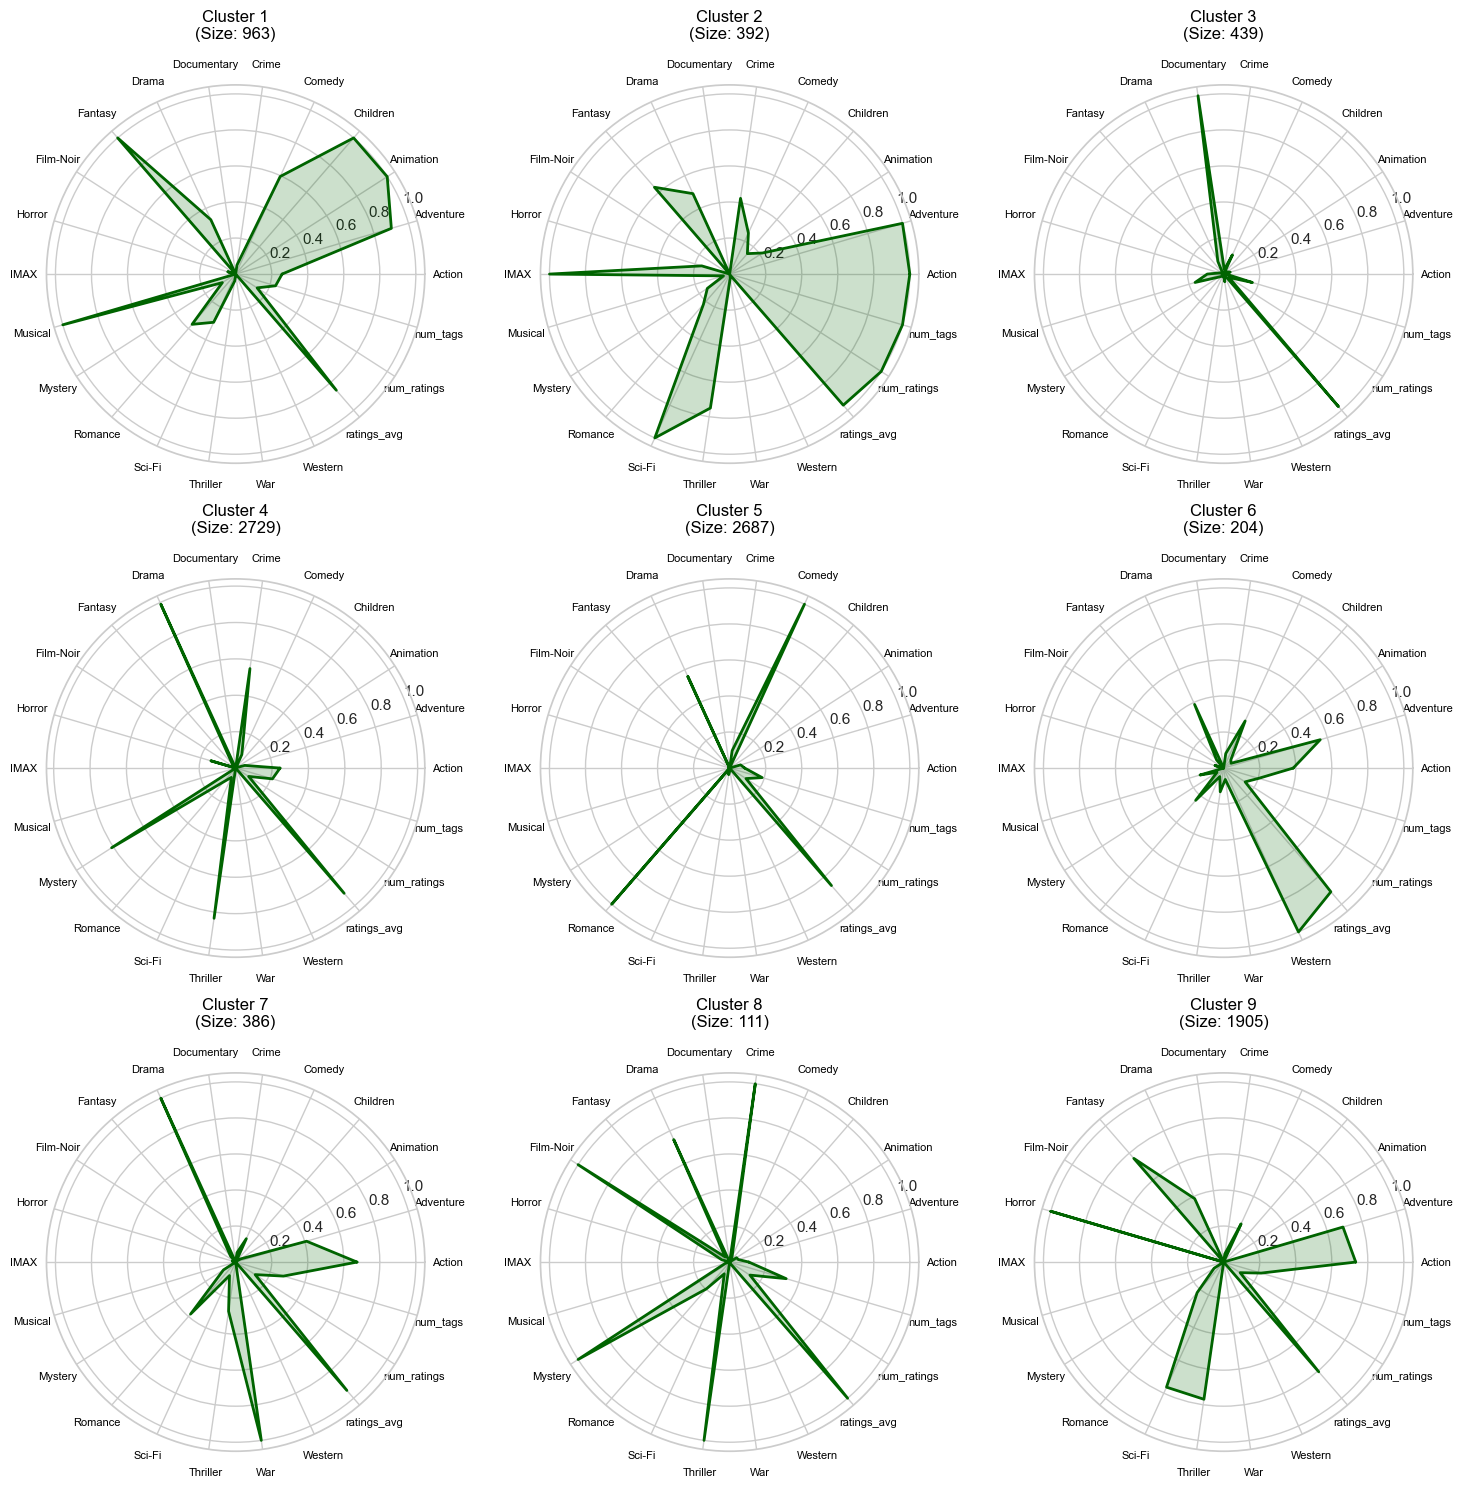

In [88]:
generate_cluster_radar_charts(data = movies_features, cluster_column = 'Cluster-ward', feature_columns = numerical_features, color = 'darkgreen')

**Cluster Analysis of Movies** (*Ward's Method*)

We analyze the 9 clusters created using *Ward's Hierarchical Clustering*. Ward's method minimizes the variance within each cluster, resulting in tightly bound clusters that group similar movies effectively.

---

**Cluster 1** (Size: 963) - *Action and Adventure Blockbusters*  
This cluster is characterized by movies rich in action, adventure, and thriller genres. These films are likely high-budget productions with broad appeal, designed to captivate large audiences with exciting and engaging storytelling. The cluster shows significant audience engagement with a high number of ratings.

---

**Cluster 2** (Size: 392) - *Family-Friendly Animated Films*  
Cluster 2 prominently features animated and children-oriented genres. These movies target families and younger audiences, with a significant emphasis on family-friendly content. Titles from major studios like Disney and Pixar are likely to dominate this cluster, showcasing consistent popularity in this demographic.

---

**Cluster 3** (Size: 439) - *Niche Horror and Suspense Thrillers*  
This cluster highlights horror and thriller genres, appealing to viewers who enjoy psychological twists, suspense, and fear-inducing narratives. These films cater to niche audiences and often exhibit moderate ratings and smaller yet dedicated fanbases.

---

**Cluster 4** (Size: 2729) - *Mass Appeal Comedies and Dramas*  
The largest cluster encompasses a broad range of comedy and drama genres. These movies are highly relatable, offering general entertainment to a wide audience. Their universal appeal makes them staples for mainstream viewing, reflected in their substantial audience engagement.

---

**Cluster 5** (Size: 2687) - *Critically Acclaimed Dramas and Documentaries*  
Cluster 5 focuses on movies that delve into intellectual and emotional storytelling, particularly documentaries and dramas. These films often engage viewers with thought-provoking narratives and reality-based content, showcasing high critical acclaim and consistent audience interest.

---

**Cluster 6** (Size: 204) - *Western and Adventure Classics*  
This is one of the smaller clusters, focusing on Western and adventure genres. These films emphasize themes of exploration, independence, and survival, appealing to audiences who enjoy nostalgic and classic cinematic storytelling.

---

**Cluster 7** (Size: 386) - *Romantic Musicals and Sentimental Favorites*  
Cluster 7 highlights musicals and romantic genres, offering emotional and uplifting themes. These films are designed for audiences seeking sentimental and feel-good experiences. Their smaller size reflects a niche but passionate fanbase for such content.

---

**Cluster 8** (Size: 111) - *Experimental and Artistic Cinema*  
This is the smallest cluster, grouping films from artistic genres such as film-noir, fantasy, and sci-fi. These movies often experiment with avant-garde storytelling techniques, appealing to cinephiles and viewers who appreciate unique and innovative narratives.

---

**Cluster 9** (Size: 1905) - *Suspenseful Action Thrillers*  
Cluster 9 groups action-packed and suspenseful thriller movies. These films engage audiences with fast-paced, intellectually stimulating plots and are a popular choice for thrill-seekers. The significant size of this cluster reflects their mainstream appeal.

---


**Differences between the three clustering algorithms**

The three clustering methods (K-means, K-means++, and Ward's Method)show distinct characteristics in their clustering outcomes. K-means tends to produce larger, broader clusters, such as mass-appeal categories like dramas and comedies, but can struggle to distinguish niche groups effectively. K-means++, with better centroid initialization, improves cluster separation, capturing smaller, niche groups more accurately while maintaining balance in size distribution. Ward's Method, using hierarchical variance minimization, creates compact, tightly focused clusters, particularly excelling at differentiating closely related genres and ensuring even size distribution across clusters. It is best suited for identifying clear subgroupings within broader categories. Each method has its strengths, with Ward's offering precision, K-means++ balancing focus and size, and K-means catering to broad analysis.

---

**Comparison of the metrics**


In [89]:
# We build a WCSS table for k-means clustering, k-means++, and Agglomerative clustering
wcss_table = pd.DataFrame({
    'Method': ['K-means', 'K-means++', 'Agglomerative (Ward)'],
    'WCSS': [metrics['wcss'][-1], metrics_pp['wcss'][-1], wcss_ward[-1]]
})
wcss_table

,Method,WCSS
0,K-means,87631.18
1,K-means++,81924.19
2,Agglomerative (Ward),87088.06


In [90]:
# Now, we build the Silhouette Score table 
silhouette_table = pd.DataFrame({
    'Method': ['K-means', 'K-means++', 'Agglomerative (Ward)'],
    'Silhouette Score': [metrics['silhouette'][-1], metrics_pp['silhouette'][-1], silhouette_scores[-1]]
})
silhouette_table

,Method,Silhouette Score
0,K-means,0.19
1,K-means++,0.24
2,Agglomerative (Ward),0.20


In [91]:
# Finally We build the Calinski-Harabasz Index one 
ch_table = pd.DataFrame({
    'Method': ['K-means', 'K-means++', 'Agglomerative (Ward)'],
    'Calinski-Harabasz Index': [metrics['calinski_harabasz'][-1], metrics_pp['calinski_harabasz'][-1], calinski_harabasz_scores[-1]]
})
ch_table

,Method,Calinski-Harabasz Index
0,K-means,1030.88
1,K-means++,1178.60
2,Agglomerative (Ward),1044.11


The comparison of clustering metrics highlights the relative strengths of each method. K-means++ outperforms the others in all metrics, demonstrating its ability to better define cluster boundaries with optimized centroid initialization. It achieves the lowest WCSS (81,924.19), the highest silhouette score (0.24), and the highest Calinski-Harabasz index (1,178.60), indicating compact and well-separated clusters.

Agglomerative clustering using Ward's Method performs slightly better than standard K-means in terms of WCSS (87,088.06 vs. 87,631.18) and the Calinski-Harabasz index (1,044.11 vs. 1,030.88), suggesting it forms more coherent clusters. However, its silhouette score (0.20) is closer to K-means (0.19), showing comparable cluster separation.

K-means, while performing slightly less effectively than the others, is computationally efficient and provides reasonable results. It can serve as a baseline or a quick method for initial analysis.

Overall, K-means++ emerges as the most effective method, offering the best balance between compactness, separation, and cluster interpretability.

# **3. Bonus Question**

In this analysis, we aim to track and visualize the iterative process of the k-means clustering algorithm. 


Previously, we applied clustering to the Principal Components derived from the movie features dataset. For visualizing the k-means algorithm's progression, it is logical to focus on the first two Principal Components (PCs), as they capture the largest share of the dataset's variance and are orthogonal by design, ensuring they represent distinct characteristics of the movies.

To facilitate this visualization, we adapted our k-means implementation to allow execution for a fixed number of iterations.

In [92]:
# We modify the previous function
def k_means_mapreduce_new(
    data: np.ndarray, 
    k: int,  
    num_iterations: int = 100
) -> tuple[np.ndarray, dict[int, list], pd.DataFrame]:
    """
    Performs K-means clustering using a MapReduce-inspired approach.

    This function implements the K-means algorithm in an iterative manner, refining cluster centroids 
    at each step by assigning points to their closest centroids and recalculating the centroids as the 
    mean of their respective assigned points. The approach is inspired by the MapReduce framework.

    Args:
        data (np.ndarray): A 2D NumPy array where each row represents a data point, 
                           and each column corresponds to a feature.
                           Shape: [n_samples, n_features].
        k (int): The number of clusters to form.
        num_iterations (int): The maximum number of iterations to run the algorithm. Defaults to 100.

    Returns:
        Tuple:
            - centroids (np.ndarray): A 2D array containing the final cluster centroids. 
                                      Shape: [k, n_features].
            - clusters (dict): A dictionary mapping cluster IDs (0 to k-1) to lists of data points 
                               assigned to each cluster.
            - labeled_data (pd.DataFrame): A Pandas DataFrame containing the original data with an 
                                           additional column indicating the cluster assignments.

    Process:
        1. We randomly initialize the centroids by selecting k data points from the dataset.
        2. In each iteration, we assign each data point to the nearest centroid.
        3. We then recalculate the centroids as the mean of all points assigned to each cluster.
        4. The algorithm iterates until the maximum number of iterations is reached.

    Example:
         centroids, clusters, labeled_data = k_means_mapreduce_new(data, k=3, num_iterations=50)
    """

    # Step 1: Randomly initialize k centroids from the data
    # We set the seed to ensure reproducibility.
    np.random.seed(46)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    iteration = 0
    while iteration < num_iterations:
        iteration += 1

        # Step 2: Map phase - Assign each data point to the nearest centroid
        # We calculate the distance from each point to each centroid and assign the point
        # to the cluster with the nearest centroid.
        mapped = defaultdict(list)
        for point in data:
            distances = [np.linalg.norm(point - centroid) for centroid in centroids]
            cluster_id = np.argmin(distances)  # Find the closest centroid
            mapped[cluster_id].append(point)

        # Step 3: Reduce phase - Compute new centroids
        # For each cluster, we compute the new centroid as the mean of its assigned points.
        new_centroids = np.array([
            np.mean(cluster_points, axis=0) if cluster_points else centroids[cluster_id]
            for cluster_id, cluster_points in mapped.items()
        ])

        # Update centroids for the next iteration
        centroids = new_centroids

    # Step 4: Prepare the final cluster assignments
    clusters = defaultdict(list)
    cluster_labels = []  # To store cluster assignments for each point
    for point in data:
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        cluster_id = np.argmin(distances)  # Assign to the nearest centroid
        clusters[cluster_id].append(point)
        cluster_labels.append(cluster_id + 1)  # Cluster IDs are 1-based

    # Step 5: Create a labeled dataset with cluster assignments
    labeled_data = pd.DataFrame(data, columns=[f"PCA_{i+1}" for i in range(data.shape[1])])
    labeled_data["Cluster"] = cluster_labels

    # Return the final centroids, clusters, and labeled dataset
    return centroids, clusters, labeled_data


Then, we define a function that returns the history of centroids and cluster labels. These are going to be used in the plotting phase.

In [93]:
def iteration_centroids(
    data: np.ndarray, 
    k: int, 
    num_iterations: int = 100
) -> tuple[pd.DataFrame, list[np.ndarray], list[np.ndarray]]:
    """
    Tracks the iterative progression of K-means clustering, capturing the history of centroids and cluster assignments
    for each iteration. This function is particularly useful for visualizing how clusters and centroids evolve over time.

    Args:
        data (np.ndarray): A 2D NumPy array of data points where each row represents a data point, 
                           and columns correspond to features. Shape: [n_samples, n_features].
        k (int): The number of clusters to form.
        num_iterations (int): The maximum number of iterations for the algorithm. Defaults to 100.

    Returns:
        Tuple:
            - labeled_data (pd.DataFrame): A DataFrame containing the original data with an additional column 
                                           for the assigned cluster labels from the final iteration.
            - centroids_history (List[np.ndarray]): A list where each element is a 2D array of centroids 
                                                   at a given iteration. Shape of each element: [k, n_features].
            - cluster_labels_history (List[np.ndarray]): A list where each element is a 1D array of cluster 
                                                         labels for all data points at a given iteration.

    Example:
         labeled_data, centroids_history, cluster_labels_history = iteration_centroids(data, k=3, num_iterations=10)

    Process:
        1. **Initialization**: For each iteration, we call the `k_means_mapreduce_new` function to perform clustering.
        2. **Capture Progress**: At every iteration, we record the centroids and cluster assignments.
        3. **Final Output**: We provide the labeled dataset, the history of centroids, and the history of cluster assignments 
           for further analysis or visualization.

    Notes:
        This function does not enforce convergence within a specific tolerance. Instead, it runs for a fixed number 
        of iterations as specified by the `num_iterations` parameter.
    """

    # We initialize two lists to store the history of centroids and cluster assignments
    centroids_history = []
    cluster_labels_history = []

    # Then we perform K-means clustering for the specified number of iterations
    for i in range(num_iterations):
        # Call the K-means function for the current number of iterations
        centroids, _, labeled_data = k_means_mapreduce_new(data, k, num_iterations=i + 1)
        
        # Record the current centroids and cluster labels
        centroids_history.append(centroids)
        cluster_labels_history.append(labeled_data['Cluster'].values)

    # Return the labeled dataset, centroids history, and cluster labels history
    return labeled_data, centroids_history, cluster_labels_history

We display the plots for each iteration, focusing on a total of 45 iterations, as our prior analysis revealed that the algorithm converges within this number of iterations. This allows us to effectively visualize the progression and refinement of cluster assignments over time.

These plots display the clustering progression from Iteration 1 to Iteration 45 during the k-means clustering process in the PCA-reduced space.

At Iteration 1, the centroids are randomly initialized, and the cluster assignments of the points (movies) show significant overlap, with poorly defined boundaries between clusters. This reflects the initial, unrefined state of the clustering process.

By Iteration 45, the centroids have moved significantly to better represent the dense regions of data points. The clusters are now more distinct, with reduced overlap, indicating that the algorithm has effectively refined the centroids and stabilized the clustering assignments.

---

**To prevent our notebook from becoming too large for GitHub, we choose to save the plots in a PDF file instead**

In GitHub repository: **Bonus_Question_kmeans_clustering_iterations.pdf**

---

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Set visualization style using Seaborn for a cleaner look
sns.set(style='whitegrid')

# Define the number of clusters for K-means
k = 9  # Number of clusters to form

# Perform K-means clustering and capture the progression of centroids and cluster labels
labeled_data, centroids_history, cluster_labels_history = iteration_centroids(
    features_pca, k=k, num_iterations=45
)

# Define the output PDF filename
pdf_filename = "kmeans_clustering_iterations.pdf"

# Save all plots to a single PDF file
with PdfPages(pdf_filename) as pdf:
    # Loop through each iteration to visualize the clustering process
    for i in range(len(cluster_labels_history)):
        plt.figure(figsize=(12, 10))  # Set the figure size for better readability
        plt.title(f'Iteration {i+1}', fontsize=16)  # Title indicating the current iteration
        
        # Scatter plot of the points, color-coded by their cluster assignment
        sns.scatterplot(
            x='PCA_1', y='PCA_2', 
            hue=cluster_labels_history[i],  # Cluster labels for the current iteration
            data=labeled_data,  # DataFrame containing the PCA-transformed data
            palette='deep',  # Use a visually distinct color palette
            legend='full',  # Display a full legend
            alpha=0.33  # Set transparency to improve visibility in dense regions
        )
        
        # Plot centroids for the current iteration with annotations
        plt.scatter(
            centroids_history[i][:, 0],  # x-coordinates of centroids
            centroids_history[i][:, 1],  # y-coordinates of centroids
            c='black', s=130, marker='x', label='Centroids'  # Style for centroids
        )
        
        # Set consistent axis limits for better comparison across iterations
        plt.xlim(-3.5, 3.5)
        plt.ylim(-1.5, 4)
        
        # Add a legend with the title "Cluster" for better context
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Cluster")
        
        # Label the axes with principal component names
        plt.xlabel('Principal Component 1', fontsize=12)
        plt.ylabel('Principal Component 2', fontsize=12)
        
        # Add a grid with slight transparency for clarity
        plt.grid(alpha=0.3)
        
        # Ensure the layout adjusts to avoid overlapping elements
        plt.tight_layout()
        
        # Save the current figure to the PDF
        pdf.savefig()  # Save the current figure to the PDF
        plt.close()  # Close the figure to free memory

# Confirm the PDF has been saved
print(f"All plots have been saved to {pdf_filename}")


All plots have been saved to kmeans_clustering_iterations.pdf
